In [3]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import numpy.random as rand
import numpy.fft as fft
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
import KenGP as gp

In [5]:
def LorenzP(xi,t, rho, sigma, beta):
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def Lorenz(xi,t):
    rho = 25.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def RosslerP(xi, t, a, b, c):    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def Sprott(xi, t):
    (x,y,z) = xi
    return ( y,-x - np.sign(z)*y, y**2 - np.exp(-x**2))

def SprottP(xi, t, d):
    (x,y,z) = xi
    return ( y, -x - np.sign(z)*y, y**2 - d*np.exp(-x**2))

def delayEmbed(Xin, Yin,assignment,embInterval):
    
    tmplen = Xin.shape[1]

    tmp = np.zeros([sum(x) for x in zip(Xin.shape,(0,sum(assignment)))])
    tmp[:,:Xin.shape[1]] = Xin
    Xin = tmp

    lag = 1
    newColInd = 0
    if len(assignment) != tmplen:
        print("Assigment list doesn't match the number of variables in data array! {a} != {b}".format(a=tmplen,b=len(assignment)),assignment)
        return
    else:
        # code that creates the lags
        for i in range(len(assignment)):
            for _ in range(assignment[i]):
                newCol = Xin[:-embInterval*lag,i]
                Xin[embInterval*lag:, tmplen + newColInd] = newCol
                newColInd += 1
                lag += 1
    Xin = Xin[embInterval*sum(assignment):]
    Yin = Yin[embInterval*sum(assignment):]
    
    # Yin = Yin[-X.shape[0]:]
    
    return (Xin, Yin)

def standardize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def CCM(X, Y, embeddingDimension, stepSize):
    Xemb, Yemb = delayEmbed(X, Y, [embeddingDimension], stepSize)
    
    N = Xemb.shape[0]
    Yest = Yemb * 0
    
    for n in range(N):
        neighborIndices = nearestNeighbors(Xemb[n,:], Xemb, embeddingDimension + 1)
        rescaledDistances = np.zeros(neighborIndices.shape[0])
        
        for ni in range(neighborIndices.shape[0]):
            rescaledDistances[ni] = np.exp(-1 * la.norm(Xemb[n]-Xemb[neighborIndices[ni]]) / la.norm(Xemb[n]-Xemb[neighborIndices[0]]) )
            
        weights = rescaledDistances / sum(rescaledDistances)
        
        Yest[n] = np.dot(weights, Y[neighborIndices])
    
    return abs(np.dot(Yemb.flatten(), Yest.flatten()) / ( la.norm(Yemb) * la.norm(Yest) ))

def nearestNeighbors(s0, S, n):
    orderedNeighbors = np.argsort(la.norm(s0 - S[:-1],axis=1))
    return orderedNeighbors[1:n+1]

# Lyapunov Edition
def lyapunovExp(S):
    Lexp = 0
    n = S.shape[0]-1
    for i in range(n):
        nearNeighborsIndices = nearestNeighbors(S[i], S, 1)
        for nni in nearNeighborsIndices:
            fprime = la.norm(S[i+1] - S[nni+1]) / la.norm(S[i] - S[nni])
            Lexp += np.log(fprime) # / la.norm(S[i] - S[nni])
    return Lexp / n # geometric mean - seems like lyapunov right?


In [6]:
settlingTime = 100

end = 2**9
tlen = 2 ** 10 + settlingTime
trainToTest = 0.5 # between 0 and 1
t = np.linspace(0, end, num=tlen)

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 3
ndrivers = 1
# t0 = np.array([0.5])
t0 = np.ones(dim) * 0.3333 # np.array([0,5,15]) * 1 # np.zeros(dim)
t0[0] += 0.1

In [7]:
"""
# Lorenz
rho = lambda t : 28 + 4*np.sin(0.7* 2*np.pi*t/tlen) # + 4*np.sin(0.75*2*np.pi*t/tlen)  # rho = 28.0# 2* (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) 
sigma = lambda t : 10.0 # + np.cos(1/2*2*np.pi * t / (tlen-2))
beta = lambda t : 8.0 / 3.0  # beta = 8.0 / 3.0

largs = lambda t : (rho(t), sigma(t), beta(t))

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(LorenzP,states[i-1],np.array([t[i-1],t[i]]),args=largs(i))[1,:]

# states = odeint(Lorenz, t0, t)
    
Xr = standardize(states[settlingTime:])
"""

# Sprott 
# dp = lambda t : 0.5 + 0.5 * t / tlen

dp = lambda t : 0.75 + 0.5 * t / tlen # + 0.25 * np.sin(3*2*np.pi*t/tlen)

largs = lambda t : (dp(t),)

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(SprottP,states[i-1],t[i-1:i+1],args=largs(i))[1,:]
Xr = standardize(states[settlingTime:])
"""
# Rossler
ap = lambda t : 0.2 # + 0.1 * (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) # 0.1 * np.sin(1.68/4*2*np.pi*t/tlen)-0.05*np.cos(0.25*2*np.pi*t/tlen) # rho = 28.0
# sigma = 10       # sigma = 10.0
bp = lambda t : 0.1 + 0.1 * np.cos( 0.70 * 2*np.pi * t / (tlen-2)) # + 0.2 * t / tlen # 
cp = lambda t : 5.7 # beta = 8.0 / 3.0

#Xr = odeint(Rossler, t0, t)

largs = lambda t : (ap(t), bp(t), cp(t))

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(RosslerP,states[i-1],t[i-1:i+1],args=largs(i))[1,:]
Xr = states
"""

'\n# Rossler\nap = lambda t : 0.2 # + 0.1 * (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) # 0.1 * np.sin(1.68/4*2*np.pi*t/tlen)-0.05*np.cos(0.25*2*np.pi*t/tlen) # rho = 28.0\n# sigma = 10       # sigma = 10.0\nbp = lambda t : 0.1 + 0.1 * np.cos( 0.70 * 2*np.pi * t / (tlen-2)) # + 0.2 * t / tlen # \ncp = lambda t : 5.7 # beta = 8.0 / 3.0\n\n#Xr = odeint(Rossler, t0, t)\n\nlargs = lambda t : (ap(t), bp(t), cp(t))\n\nstates = np.zeros((tlen,3))\nstates[0] = t0\nfor i in range(1, tlen ):\n    # print(largs(i))\n    states[i] = odeint(RosslerP,states[i-1],t[i-1:i+1],args=largs(i))[1,:]\nXr = states\n'

In [8]:
""" UPDATE DRIVERS HERE """
digiDrivers = [dp]

gtsr = np.zeros((Xr.shape[0], ndrivers))
for ind in range(len(digiDrivers)):
    tmp = np.fromfunction(lambda i : digiDrivers[ind](i), (Xr.shape[0],) , dtype = float)# time series of gmax
    gtsr[:,ind] = tmp

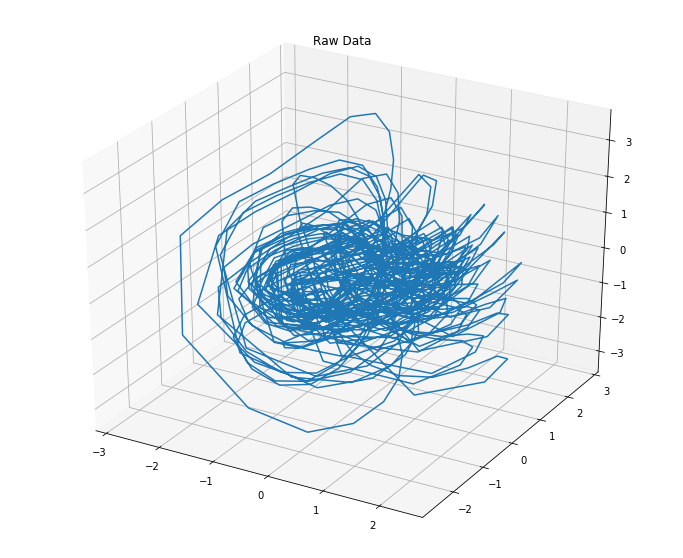

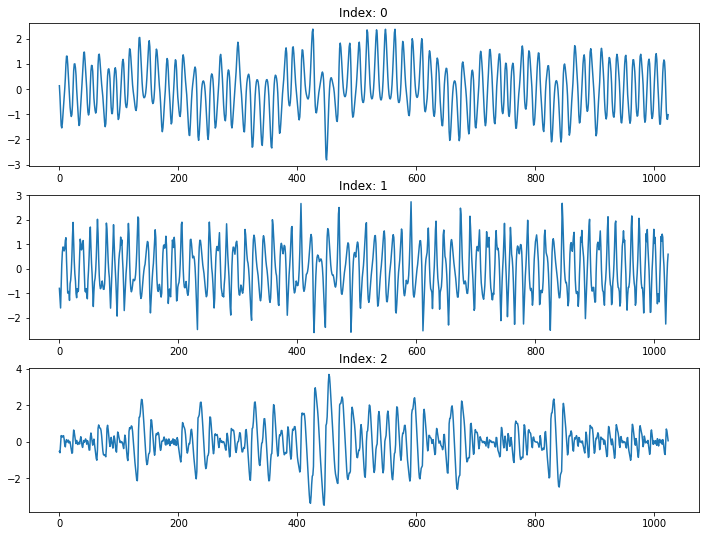

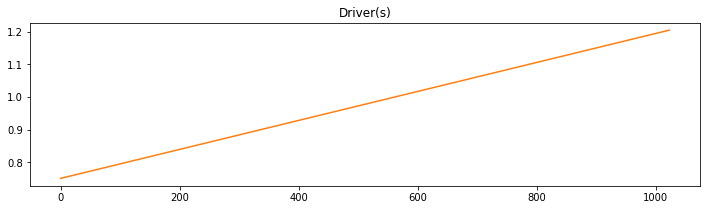

In [9]:
fig2 = plt.figure(2,figsize=(12,10))
if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],Xr[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2])
ax2.set_title("Raw Data")

if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(12,dim*3))
    axTS[0].set_title("Cross section Time Series")
    for i in range(dim):
        axTS[i].set_title("Index: {ind}".format(ind=i))
        axTS[i].plot(Xr[:,i])

if ndrivers != 0:
    figD, axD = plt.subplots(ndrivers, figsize=(12,ndrivers*3))
    if ndrivers == 1:
        axD.set_title("Driver(s)")
        axD.plot(gtsr, c="tab:orange")
    else:
        axD[0].set_title("Driver(s)")
        for d in range(ndrivers):
            axD[d].plot(gtsr[:,d], c="tab:orange")
        
plt.show()

In [10]:
X = standardize(Xr[:-1,1,None])
Y = standardize(Xr[1:,1,None])

gts = standardize(gtsr)
# gts = gtsr

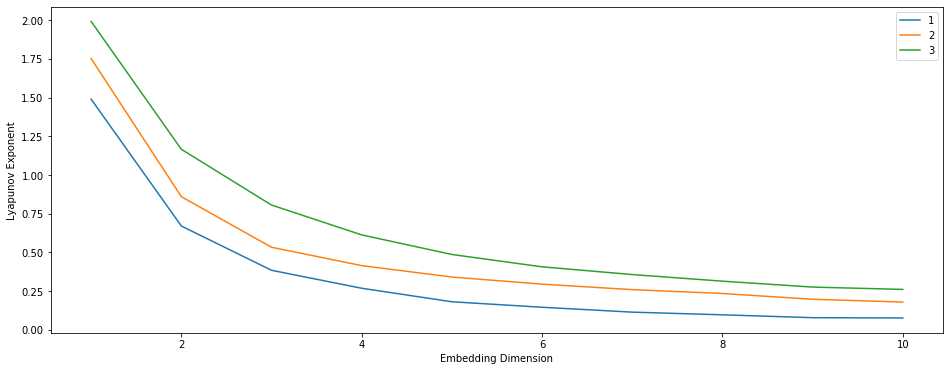

In [201]:
# False Nearest Neighbors Test

# Unitary Embedding Testing

l = 10
c = 1
st = 3

# figFNN, axFNN = plt.subplots(2 * c,figsize=(16, 3*(2*c)))
figFNN, axFNN = plt.subplots(c, figsize=(16, 6*c))
# figFNN = plt.figure(figsize=(12, 8))
# axFNN = figFNN.add_subplot()

for c in range(1, c+1):
    lyapExps = np.zeros(l)
    for s in range(1, st+1, 1):
        for i in range(1, l+1):
            embeddedVersion, _ = delayEmbed(X[::c], X[::c], [i]*1,s)
            # Y, _ = delayEmbedUnitary(Xr[::c], Xr[::c], i,s)
            lyapExps[i-1] = lyapunovExp(embeddedVersion)
            
        axFNN.plot(range(1,l+1), lyapExps, label="{e}".format(e=s))

    axFNN.legend()
    axFNN.set_xlabel("Embedding Dimension")
    # axFNN[c-1].set_title("Slice = {ind}".format(ind=c))
    axFNN.set_ylabel("Lyapunov Exponent")
    
plt.show()

c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars


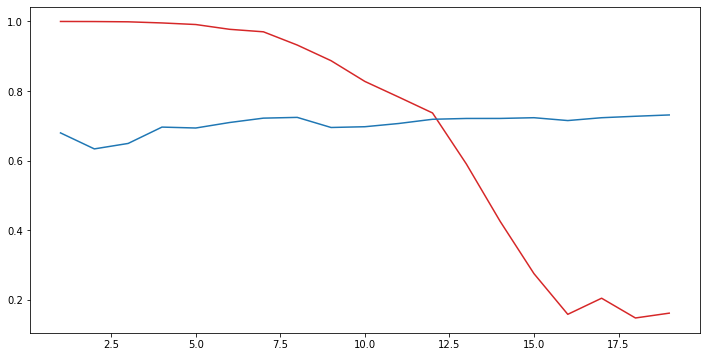

In [191]:
start = 8
interval = 50
CCMValues = np.zeros( ( int((Xr.shape[0]-start)/interval), 2 ) )
for L in range(start, Xr.shape[0]-interval,interval):
    CCMValues[int((L-start)/interval), 0] = CCM(X[:L], gts[:L], 8, 1)
    CCMValues[int((L-start)/interval), 1] = CCM(gts[:L], X[:L], 8, 1)
    # CCMValues[int((L-start)/interval), 0] = CCM(standardize(Xr[:L,1,None]), gts)
    # CCMValues[int((L-start)/interval), 1] = CCM(gts, standardize(Xr[:L,1,None])
    
    # print(CCMValues[int((L-start)/10), 0], CCMValues[int((L-start)/10), 1])

figCCM, axCCM = plt.subplots(1, figsize=(12, 3 * 2))
axCCM.plot(CCMValues[:,0], c="tab:red")
axCCM.plot(CCMValues[:,1], c="tab:blue")

plt.show()

In [11]:
embdim = 4
Xemb, Yemb = delayEmbed(X, Y, [embdim], 1)
# gts = gtsr[-Xemb.shape[0]:]

Prior dict  {0: 'none', 1: 'none', 2: 'half-normal', 3: 'exponential', 4: 'none', 5: 'none', 6: 'none', 7: 'none', 8: 'none', 9: 'none', 10: 'none', 11: 'none'}
Covariance function set to  sqrexp
Data input success
Gradient:  [-0.93816469 -0.0812978  -0.33650807]
Likelihood:  387.2315606928976
Hp:  [0.45 0.45 0.45]  #  1
Gradient:  [-0.93921695 -0.05782767 -0.3384191 ]
Likelihood:  469.8743282972183
Hp:  [0.39 0.39 0.39]  #  2
Gradient:  [-0.93986793 -0.01637103 -0.34114551]
Likelihood:  571.619380267859
Hp:  [0.318 0.318 0.318]  #  3
Gradient:  [-0.93305982  0.09106167 -0.34800452]
Likelihood:  687.1585202676512
Hp:  [0.2316 0.354  0.2316]  #  4
Gradient:  [ 0.09270128  0.86529545 -0.49261573]
Likelihood:  775.6001440859762
Hp:  [0.2748  0.3972  0.12792]  #  5
Gradient:  [-0.79400879  0.24646875  0.55570063]
Likelihood:  759.8454566902107
Hp:  [0.2532  0.44904 0.17976]  #  6
Gradient:  [-0.96251762  0.26323051 -0.06534161]
Likelihood:  780.5948911458646
Hp:  [0.22728  0.511248 0.15384

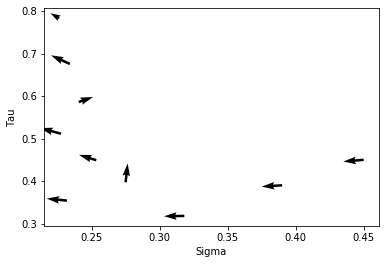

794.126337568171
Data input success
Gradient:  [ 0.74788979  0.0565799  -0.66140728]
Likelihood:  789.1764482797028
Hp:  [0.345984   0.90297254 0.124576  ]  #  1
Gradient:  [-0.97496179  0.00143146 -0.22236786]
Likelihood:  696.2036961390935
Hp:  [0.285984   1.04697254 0.064576  ]  #  2
Gradient:  [-0.33005581  0.02496336  0.94363128]
Likelihood:  750.3604683425706
Hp:  [0.213984   1.21977254 0.094576  ]  #  3
Gradient:  [0.62638627 0.01995177 0.77925745]
Likelihood:  772.3617611823328
Hp:  [0.249984   1.42713254 0.130576  ]  #  4
Gradient:  [-0.81678376 -0.02062439 -0.57657516]
Likelihood:  791.1775938539536
Hp:  [0.231984   1.32345254 0.112576  ]  #  5
Gradient:  [0.51326441 0.023182   0.85791739]
Likelihood:  793.2498520032005
Hp:  [0.240984   1.37529254 0.121576  ]  #  6
Gradient:  [-0.9985955  -0.00852257 -0.05229149]
Likelihood:  794.4359612206528
Hp:  [0.236484   1.34937254 0.117076  ]  #  7
Gradient:  [0.2001081  0.02435512 0.97947107]
Likelihood:  794.4662663606867
Hp:  [0.238

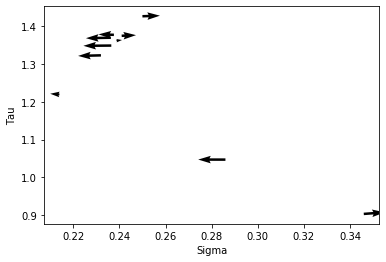

Data input success
Gradient:  [-0.20815525  0.01078966  0.97803628]
Likelihood:  800.2165505766735
Hp:  [0.186259   1.49010854 0.245266  ]  #  1
Gradient:  [ 0.97020838 -0.02593689 -0.24087958]
Likelihood:  765.3746397149905
Hp:  [0.211259   1.43010854 0.185266  ]  #  2
Gradient:  [ 0.86439568 -0.04166402 -0.50108304]
Likelihood:  795.6814144049782
Hp:  [0.241259   1.35810854 0.113266  ]  #  3
Gradient:  [-0.23237006  0.01689528  0.9724807 ]
Likelihood:  797.3067957459899
Hp:  [0.226259   1.39410854 0.149266  ]  #  4
Gradient:  [ 0.98287197 -0.07732458  0.16728299]
Likelihood:  801.9426054792235
Hp:  [0.233759   1.37610854 0.192466  ]  #  5
Gradient:  [-0.56254093 -0.05177377 -0.82514676]
Likelihood:  795.341979671656
Hp:  [0.230009   1.35450854 0.170866  ]  #  6
Gradient:  [-0.45898601 -0.06089791 -0.88635393]
Likelihood:  800.6317062198901
Hp:  [0.225509   1.32858854 0.144946  ]  #  7
Gradient:  [ 0.77389262 -0.01000739  0.63323776]
Likelihood:  801.8496990450202
Hp:  [0.227759   1.2

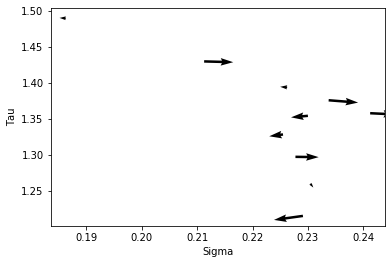

802.5945671777863
Data input success
Gradient:  [ 0.59599671 -0.0383842  -0.80206894]
Likelihood:  789.610920364282
Hp:  [0.349109   1.16536998 0.104666  ]  #  1
Gradient:  [-0.98792126 -0.0021582  -0.1549417 ]
Likelihood:  693.8591685340849
Hp:  [0.289109   1.10536998 0.044666  ]  #  2
Gradient:  [-0.11138747  0.0152881   0.99365945]
Likelihood:  722.7601510567481
Hp:  [0.217109   1.13536998 0.074666  ]  #  3
Gradient:  [0.47404751 0.0186785  0.88030113]
Likelihood:  746.7059356908339
Hp:  [0.253109   1.17136998 0.110666  ]  #  4
Gradient:  [-0.66217737  0.0263178   0.74888484]
Likelihood:  786.571732421156
Hp:  [0.235109   1.21456998 0.153866  ]  #  5
Gradient:  [-0.15065633 -0.04489123 -0.98756643]
Likelihood:  790.0299816581435
Hp:  [0.213509   1.19296998 0.132266  ]  #  6
Gradient:  [0.93553281 0.01175784 0.35304407]
Likelihood:  781.0365532722643
Hp:  [0.224309   1.20376998 0.143066  ]  #  7
Gradient:  [ 0.99984704 -0.00141027  0.0174327 ]
Likelihood:  788.9642498376826
Hp:  [0.2

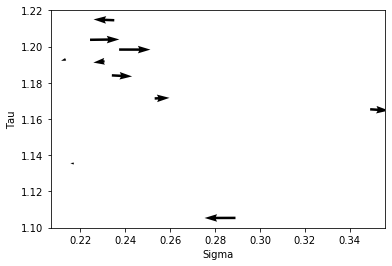

Data input success
Gradient:  [ 0.29343015 -0.03776588 -0.95523426]
Likelihood:  793.2783975227239
Hp:  [0.354029   1.13411398 0.09177   ]  #  1
Gradient:  [-0.99999354  0.00338301 -0.00121646]
Likelihood:  689.3908735585787
Hp:  [0.294029   1.15911398 0.03177   ]  #  2
Gradient:  [-0.0400112   0.01007818  0.9991484 ]
Likelihood:  687.5461318276386
Hp:  [0.222029   1.18911398 0.06177   ]  #  3
Gradient:  [0.35226464 0.01571317 0.93576852]
Likelihood:  739.3185798788445
Hp:  [0.258029   1.22511398 0.09777   ]  #  4
Gradient:  [-0.5438994   0.0221121   0.83885905]
Likelihood:  785.3213001639607
Hp:  [0.240029   1.26831398 0.14097   ]  #  5
Gradient:  [-0.52735056 -0.03786459 -0.84880366]
Likelihood:  792.6998145427522
Hp:  [0.218429   1.24671398 0.11937   ]  #  6
Gradient:  [0.86026842 0.01354339 0.50966148]
Likelihood:  786.0882692395238
Hp:  [0.229229   1.25751398 0.13017   ]  #  7
Gradient:  [ 9.78555302e-01 -4.14513765e-05  2.05984268e-01]
Likelihood:  792.7682308755444
Hp:  [0.24218

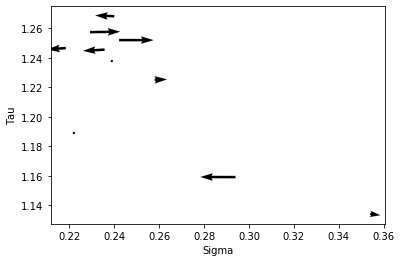

Data input success
Gradient:  [ 0.15520045 -0.02270396 -0.98762207]
Likelihood:  786.6832981749264
Hp:  [0.358949   1.18785798 0.078874  ]  #  1
Gradient:  [-0.99162701  0.00671776  0.12896021]
Likelihood:  682.9022912867232
Hp:  [0.298949   1.21285798 0.103874  ]  #  2
Gradient:  [-9.92243627e-01 -1.85600293e-04 -1.24308287e-01]
Likelihood:  754.0360197979828
Hp:  [0.226949   1.20035798 0.091374  ]  #  3
Gradient:  [0.56241231 0.02197899 0.82656477]
Likelihood:  775.7580708536146
Hp:  [0.262949   1.20660798 0.097624  ]  #  4
Gradient:  [-0.81300188  0.02133896  0.58186991]
Likelihood:  780.6103260041771
Hp:  [0.244949   1.21410798 0.105124  ]  #  5
Gradient:  [-0.09554669  0.0369279   0.99473974]
Likelihood:  786.0889513520839
Hp:  [0.223349   1.22310798 0.114124  ]  #  6
Gradient:  [0.90217276 0.01547852 0.43109712]
Likelihood:  780.9679001086743
Hp:  [0.234149   1.23390798 0.124924  ]  #  7
Gradient:  [ 0.97830429  0.00204429 -0.20716305]
Likelihood:  786.3563630386317
Hp:  [0.24710

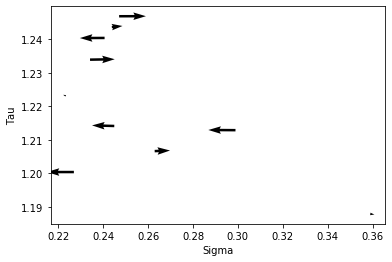

Data input success
Gradient:  [-0.90519071  0.10069483  0.41290474]
Likelihood:  782.4344164172529
Hp:  [0.193869   1.36362798 0.236284  ]  #  1
Gradient:  [ 0.98984524 -0.01936124 -0.14082453]
Likelihood:  736.4960430784635
Hp:  [0.218869   1.30362798 0.176284  ]  #  2
Gradient:  [ 0.8402406  -0.03098525 -0.54132767]
Likelihood:  768.3680255955704
Hp:  [0.248869   1.23162798 0.104284  ]  #  3
Gradient:  [-0.35726019  0.03270932  0.93343198]
Likelihood:  781.4361991490922
Hp:  [0.233869   1.26762798 0.140284  ]  #  4
Gradient:  [ 0.56120748 -0.030019   -0.82713059]
Likelihood:  779.8343496391866
Hp:  [0.241369   1.24962798 0.122284  ]  #  5
Gradient:  [ 0.33087049 -0.01670298 -0.94352834]
Likelihood:  782.2987349116221
Hp:  [0.250369   1.22802798 0.100684  ]  #  6
Gradient:  [-0.3249853   0.03069975  0.94522065]
Likelihood:  780.7647002824632
Hp:  [0.245869   1.23882798 0.111484  ]  #  7
Gradient:  [-0.46143878  0.04152622  0.88619965]
Likelihood:  782.2507864725252
Hp:  [0.240469   1.

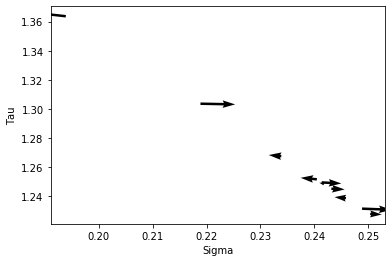

Data input success
Gradient:  [0.13522562 0.02343485 0.99053765]
Likelihood:  783.2673952368426
Hp:  [0.361819   1.36854798 0.230188  ]  #  1
Gradient:  [-0.86531934 -0.03440072 -0.50003904]
Likelihood:  631.5336432426076
Hp:  [0.301819   1.30854798 0.170188  ]  #  2
Gradient:  [-0.87866235 -0.02429774 -0.47682501]
Likelihood:  734.8214445936001
Hp:  [0.229819   1.23654798 0.098188  ]  #  3
Gradient:  [0.51254193 0.01977338 0.8584345 ]
Likelihood:  775.3457428830174
Hp:  [0.265819   1.27254798 0.134188  ]  #  4
Gradient:  [-0.94945175 -0.01476865 -0.3135654 ]
Likelihood:  776.5534269199857
Hp:  [0.247819   1.25454798 0.116188  ]  #  5
Gradient:  [-0.55413259  0.01725192  0.83224963]
Likelihood:  783.9773448388654
Hp:  [0.226219   1.26354798 0.125188  ]  #  6
Gradient:  [0.81762818 0.0121328  0.57561876]
Likelihood:  782.073348418837
Hp:  [0.237019   1.27434798 0.135988  ]  #  7
Gradient:  [ 0.72790321 -0.04933378  0.68390284]
Likelihood:  785.828826535411
Hp:  [0.249979   1.26894798 0.

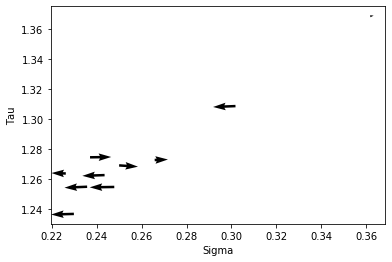

Data input success
Gradient:  [ 0.41011107 -0.02870601 -0.91158372]
Likelihood:  787.4865974287034
Hp:  [0.355723   1.20469198 0.084692  ]  #  1
Gradient:  [-0.99837433  0.00444972  0.05682346]
Likelihood:  684.5545906884765
Hp:  [0.295723   1.22969198 0.109692  ]  #  2
Gradient:  [-9.95836963e-01 -5.65960471e-04 -9.11505538e-02]
Likelihood:  755.135450017083
Hp:  [0.223723   1.21719198 0.097192  ]  #  3
Gradient:  [0.56119469 0.0213231  0.82740911]
Likelihood:  774.8174588006956
Hp:  [0.259723   1.22344198 0.103442  ]  #  4
Gradient:  [-0.75043341  0.02108373  0.6606097 ]
Likelihood:  781.1421577213454
Hp:  [0.241723   1.23094198 0.110942  ]  #  5
Gradient:  [0.00302132 0.03186317 0.99948767]
Likelihood:  786.4202199738635
Hp:  [0.250723   1.23994198 0.119942  ]  #  6
Gradient:  [-0.99290701  0.00747269  0.11865846]
Likelihood:  785.9508106428344
Hp:  [0.246223   1.25074198 0.130742  ]  #  7
Gradient:  [-0.84643765 -0.01529485 -0.53226814]
Likelihood:  786.8042442894064
Hp:  [0.240823

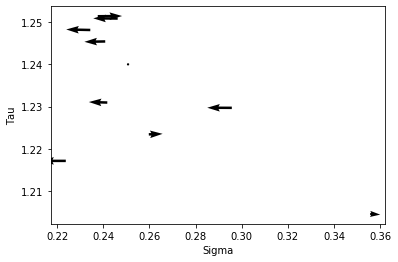

Data input success
Gradient:  [-0.30056404  0.01466391  0.9536489 ]
Likelihood:  796.5383238649702
Hp:  [0.187583   1.37128198 0.251282  ]  #  1
Gradient:  [ 0.98363981 -0.02390598 -0.17855316]
Likelihood:  763.1966890335473
Hp:  [0.212583   1.31128198 0.191282  ]  #  2
Gradient:  [ 0.89529016 -0.04036638 -0.44365087]
Likelihood:  791.47710516995
Hp:  [0.242583   1.23928198 0.119282  ]  #  3
Gradient:  [-0.32400866  0.02186266  0.94580147]
Likelihood:  794.2026944520645
Hp:  [0.227583   1.27528198 0.155282  ]  #  4
Gradient:  [ 0.99179159 -0.07258506 -0.10526566]
Likelihood:  797.6230894119888
Hp:  [0.235083   1.25728198 0.137282  ]  #  5
Gradient:  [-0.21767835  0.00495127  0.976008  ]
Likelihood:  797.23576472212
Hp:  [0.231333   1.26628198 0.146282  ]  #  6
Gradient:  [ 0.35322697 -0.04306845  0.93454578]
Likelihood:  797.7382034959551
Hp:  [0.233208   1.26178198 0.157082  ]  #  7
Gradient:  [-0.7284337  -0.07301197 -0.6812148 ]
Likelihood:  797.6197726276383
Hp:  [0.2322705  1.2563

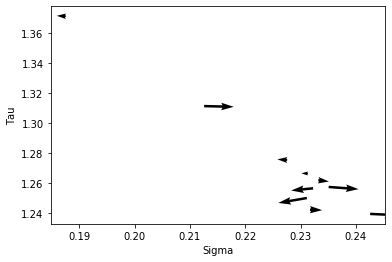

Data input success
Gradient:  [ 0.86225306 -0.03438815 -0.50530894]
Likelihood:  778.4669152631733
Hp:  [0.351708   1.19212598 0.098442  ]  #  1
Gradient:  [-0.98680831 -0.00255139 -0.16187294]
Likelihood:  688.7003995938094
Hp:  [0.291708   1.13212598 0.038442  ]  #  2
Gradient:  [-0.06956112  0.01249974  0.99749938]
Likelihood:  706.5705343995835
Hp:  [0.219708   1.16212598 0.068442  ]  #  3
Gradient:  [0.48445558 0.01625939 0.87466475]
Likelihood:  734.3989540165087
Hp:  [0.255708   1.19812598 0.104442  ]  #  4
Gradient:  [-0.59809205  0.0237206   0.8010763 ]
Likelihood:  776.9298561716782
Hp:  [0.237708   1.24132598 0.147642  ]  #  5
Gradient:  [ 0.14112067 -0.05587347 -0.98841444]
Likelihood:  779.2392005240015
Hp:  [0.246708   1.21972598 0.126042  ]  #  6
Gradient:  [-0.98942555 -0.01230479 -0.14451879]
Likelihood:  780.0524998239237
Hp:  [0.242208   1.19380598 0.100122  ]  #  7
Gradient:  [0.26685913 0.02604627 0.96338352]
Likelihood:  776.4855607967567
Hp:  [0.244458   1.206765

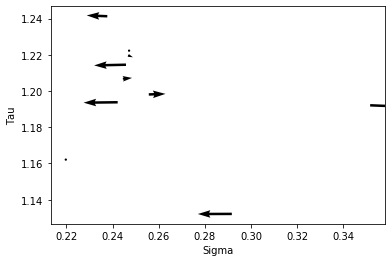

Data input success
Gradient:  [-0.64096954  0.02201017  0.76725068]
Likelihood:  793.0165645569904
Hp:  [0.195808   1.33454198 0.240858  ]  #  1
Gradient:  [ 0.93845248 -0.03310734 -0.34381805]
Likelihood:  766.3079581806132
Hp:  [0.220808   1.27454198 0.180858  ]  #  2
Gradient:  [ 0.60406198 -0.05302126 -0.7951716 ]
Likelihood:  791.4591738074671
Hp:  [0.250808   1.20254198 0.108858  ]  #  3
Gradient:  [-0.49351822  0.02511829  0.86937267]
Likelihood:  789.5193443705908
Hp:  [0.235808   1.23854198 0.144858  ]  #  4
Gradient:  [-0.89795041 -0.04574117 -0.43771316]
Likelihood:  795.8155947167077
Hp:  [0.217808   1.22054198 0.126858  ]  #  5
Gradient:  [0.79462647 0.01717878 0.60685555]
Likelihood:  788.7687869028807
Hp:  [0.226808   1.22954198 0.135858  ]  #  6
Gradient:  [0.78254791 0.01445135 0.62242262]
Likelihood:  794.6980112910813
Hp:  [0.237608   1.24034198 0.146658  ]  #  7
Gradient:  [-0.86402056 -0.03563785 -0.50219361]
Likelihood:  795.5507784543348
Hp:  [0.232208   1.234941

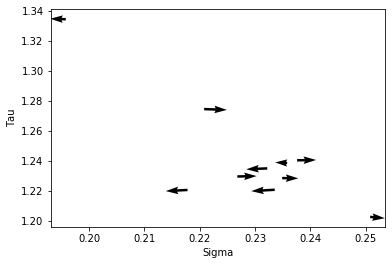

Data input success
Gradient:  [ 0.10317871 -0.02633042 -0.99431427]
Likelihood:  795.9670088843095
Hp:  [0.353558   1.17068598 0.092608  ]  #  1
Gradient:  [-0.99778417  0.00233221 -0.06649291]
Likelihood:  693.2205276778923
Hp:  [0.293558   1.19568598 0.032608  ]  #  2
Gradient:  [-0.045297    0.01005517  0.99892296]
Likelihood:  692.8571627107576
Hp:  [0.221558   1.22568598 0.062608  ]  #  3
Gradient:  [0.35058392 0.0164306  0.93638718]
Likelihood:  751.3429246363918
Hp:  [0.257558   1.26168598 0.098608  ]  #  4
Gradient:  [-0.73779398  0.02218008  0.67466146]
Likelihood:  790.6171973685018
Hp:  [0.239558   1.30488598 0.141808  ]  #  5
Gradient:  [-0.48939406 -0.02977842 -0.87155418]
Likelihood:  795.2963412529919
Hp:  [0.217958   1.28328598 0.120208  ]  #  6
Gradient:  [0.92069268 0.01311889 0.39006781]
Likelihood:  790.1974020193813
Hp:  [0.228758   1.29408598 0.131008  ]  #  7
Gradient:  [ 0.98535741 -0.00193597 -0.17049055]
Likelihood:  796.0043174273611
Hp:  [0.241718   1.288685

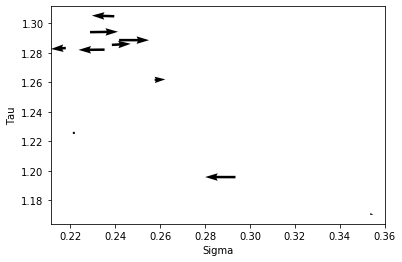

Data input success
Gradient:  [-0.63076658  0.03729924  0.77507566]
Likelihood:  794.4101563390938
Hp:  [0.188478   1.40544598 0.242368  ]  #  1
Gradient:  [ 0.97375129 -0.02110829 -0.22663376]
Likelihood:  743.6859924409272
Hp:  [0.213478   1.34544598 0.182368  ]  #  2
Gradient:  [ 0.77571733 -0.0323923  -0.63024865]
Likelihood:  780.368589826518
Hp:  [0.243478   1.27344598 0.110368  ]  #  3
Gradient:  [-0.3672795   0.03033024  0.92961596]
Likelihood:  792.9176519539584
Hp:  [0.228478   1.30944598 0.146368  ]  #  4
Gradient:  [ 0.4992713  -0.03228594 -0.86584398]
Likelihood:  792.4023834324024
Hp:  [0.235978   1.29144598 0.128368  ]  #  5
Gradient:  [-0.01066464 -0.01712656 -0.99979645]
Likelihood:  794.4791056481959
Hp:  [0.232228   1.26984598 0.106768  ]  #  6
Gradient:  [0.4162925  0.0263786  0.90884802]
Likelihood:  791.4230768959546
Hp:  [0.234103   1.28064598 0.117568  ]  #  7
Gradient:  [0.48079295 0.02977136 0.87632859]
Likelihood:  793.9151289415378
Hp:  [0.236353   1.2936059

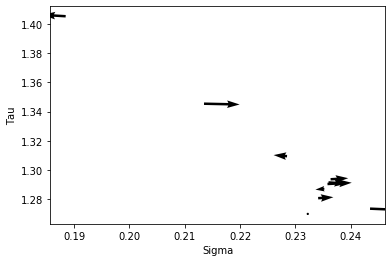

Data input success
Gradient:  [0.63529777 0.00660727 0.77223901]
Likelihood:  785.0199021687487
Hp:  [0.3557905  1.41036598 0.247288  ]  #  1
Gradient:  [-0.8586519  -0.03742048 -0.51119138]
Likelihood:  631.6652690715131
Hp:  [0.2957905  1.35036598 0.187288  ]  #  2
Gradient:  [-0.85721358 -0.02891491 -0.51414863]
Likelihood:  735.2100028292854
Hp:  [0.2237905  1.27836598 0.115288  ]  #  3
Gradient:  [0.76075014 0.01460955 0.64888041]
Likelihood:  778.2015398568276
Hp:  [0.2597905  1.31436598 0.151288  ]  #  4
Gradient:  [-0.86625426 -0.02566957 -0.49894351]
Likelihood:  777.3359505320335
Hp:  [0.2417905  1.29636598 0.133288  ]  #  5
Gradient:  [-0.99854933 -0.04390142  0.03117544]
Likelihood:  785.3731868071841
Hp:  [0.2201905  1.27476598 0.142288  ]  #  6
Gradient:  [0.96065877 0.00161264 0.27772671]
Likelihood:  780.6097321101265
Hp:  [0.2309905  1.28556598 0.153088  ]  #  7
Gradient:  [ 0.86547392 -0.05546084 -0.49787446]
Likelihood:  784.7418346406616
Hp:  [0.2439505  1.28016598 

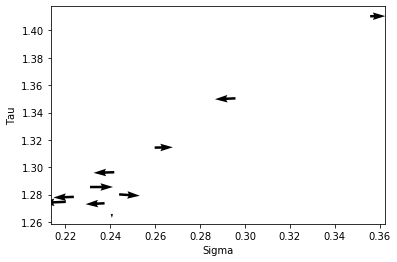

Data input success
Gradient:  [-0.98090144 -0.00808467  0.19433735]
Likelihood:  801.0004549079422
Hp:  [0.1907105  1.21590998 0.253432  ]  #  1
Gradient:  [ 0.93923099 -0.03508111 -0.34148861]
Likelihood:  767.7054098527677
Hp:  [0.2157105  1.15590998 0.193432  ]  #  2
Gradient:  [ 0.62140106 -0.05367033 -0.78165224]
Likelihood:  796.3115286106034
Hp:  [0.2457105  1.08390998 0.121432  ]  #  3
Gradient:  [-0.61672947  0.03263438  0.78649842]
Likelihood:  798.0499849465572
Hp:  [0.2307105  1.11990998 0.157432  ]  #  4
Gradient:  [-0.45158767 -0.05025276 -0.89081044]
Likelihood:  802.3632580498435
Hp:  [0.2127105  1.10190998 0.139432  ]  #  5
Gradient:  [0.87234166 0.01848996 0.48854697]
Likelihood:  795.472486527185
Hp:  [0.2217105  1.11090998 0.148432  ]  #  6
Gradient:  [0.92779934 0.01266008 0.37286474]
Likelihood:  801.3346941130982
Hp:  [0.2325105  1.12170998 0.159232  ]  #  7
Gradient:  [-0.61588094 -0.04272115 -0.78668009]
Likelihood:  802.0778863605993
Hp:  [0.2271105  1.1163099

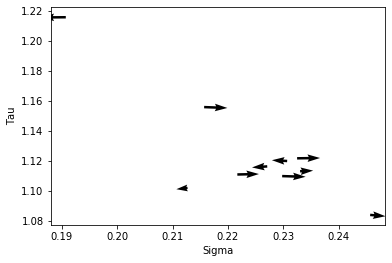

Data input success
Gradient:  [-0.29142424 -0.02062154 -0.95637161]
Likelihood:  807.3002643122065
Hp:  [0.1830505  1.06306998 0.100592  ]  #  1
Gradient:  [0.86098168 0.01748299 0.50833541]
Likelihood:  731.8715510557555
Hp:  [0.2080505  1.08806998 0.125592  ]  #  2
Gradient:  [0.93967043 0.02021168 0.34148348]
Likelihood:  796.731733729689
Hp:  [0.2380505  1.11806998 0.155592  ]  #  3
Gradient:  [-0.52989219 -0.02436901 -0.84771482]
Likelihood:  805.4506520531213
Hp:  [0.2230505  1.10306998 0.140592  ]  #  4
Gradient:  [ 0.94334827  0.01260568 -0.33156467]
Likelihood:  807.542897032248
Hp:  [0.2305505  1.11056998 0.122592  ]  #  5
Gradient:  [0.6616486  0.07348674 0.74620428]
Likelihood:  809.0016164552518
Hp:  [0.2395505  1.11956998 0.131592  ]  #  6
Gradient:  [-0.84056863  0.01034068 -0.54160635]
Likelihood:  808.5364422756536
Hp:  [0.2350505  1.13036998 0.127092  ]  #  7
Gradient:  [-0.93162207  0.10545262 -0.34779315]
Likelihood:  809.3353838422192
Hp:  [0.2296505  1.14332998 0.

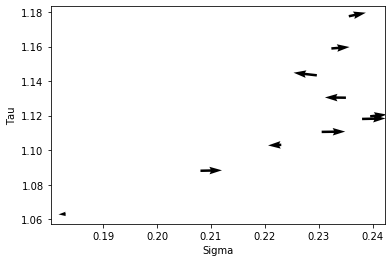

Data input success
Gradient:  [-0.03863103  0.02879857  0.99883847]
Likelihood:  798.8030597719784
Hp:  [0.1855905  1.29754438 0.247632  ]  #  1
Gradient:  [ 0.98554761 -0.0208481  -0.16811084]
Likelihood:  764.960578532527
Hp:  [0.2105905  1.23754438 0.187632  ]  #  2
Gradient:  [ 0.9453146  -0.02911302 -0.32485803]
Likelihood:  795.062908770941
Hp:  [0.2405905  1.16554438 0.115632  ]  #  3
Gradient:  [-0.12899618  0.02936524  0.9912102 ]
Likelihood:  795.7438396264847
Hp:  [0.2255905  1.20154438 0.151632  ]  #  4
Gradient:  [ 0.86239396 -0.00393647  0.50622244]
Likelihood:  800.8661104579417
Hp:  [0.2330905  1.18354438 0.194832  ]  #  5
Gradient:  [-0.56386503 -0.05342053 -0.82413741]
Likelihood:  796.2273782385942
Hp:  [0.2293405  1.16194438 0.173232  ]  #  6
Gradient:  [-0.39753104 -0.06109273 -0.9155527 ]
Likelihood:  800.4497097687856
Hp:  [0.2248405  1.13602438 0.147312  ]  #  7
Gradient:  [0.73486009 0.02045093 0.67791032]
Likelihood:  800.3400610073952
Hp:  [0.2270905  1.14898

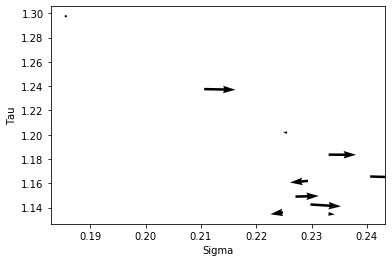

Data input success
Gradient:  [-0.97067764 -0.02796502 -0.23875274]
Likelihood:  802.1985713050676
Hp:  [0.1830305  1.08472838 0.107032  ]  #  1
Gradient:  [0.80817594 0.01723922 0.58868877]
Likelihood:  715.9679032605796
Hp:  [0.2080305  1.10972838 0.132032  ]  #  2
Gradient:  [0.80351853 0.0208018  0.59491618]
Likelihood:  787.3941885401971
Hp:  [0.2380305  1.13972838 0.162032  ]  #  3
Gradient:  [-0.89448116 -0.02742091 -0.44626399]
Likelihood:  800.9767651833663
Hp:  [0.2230305  1.12472838 0.147032  ]  #  4
Gradient:  [0.753658   0.02195917 0.65689985]
Likelihood:  800.9828464188851
Hp:  [0.2305305  1.13222838 0.154532  ]  #  5
Gradient:  [-0.6506243  -0.01518431  0.75924796]
Likelihood:  802.3800147727187
Hp:  [0.2267805  1.12847838 0.163532  ]  #  6
Gradient:  [ 0.7427857  -0.07232933 -0.6656109 ]
Likelihood:  802.339974222597
Hp:  [0.2286555  1.12397838 0.159032  ]  #  7
Gradient:  [ 0.9673137  -0.24273139 -0.07338714]
Likelihood:  802.4386028458255
Hp:  [0.2309055  1.11857838 0

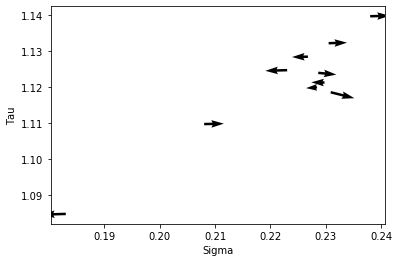

Data input success
Gradient:  [ 0.62021281 -0.02911738 -0.78389301]
Likelihood:  777.9079614762786
Hp:  [0.3484305  1.06992838 0.109572  ]  #  1
Gradient:  [-0.96487862 -0.00373052 -0.26266964]
Likelihood:  694.2433897042098
Hp:  [0.2884305  1.00992838 0.049572  ]  #  2
Gradient:  [-0.14573424  0.01948046  0.98913196]
Likelihood:  730.986549807288
Hp:  [0.2164305  1.03992838 0.079572  ]  #  3
Gradient:  [0.58105131 0.02246021 0.81355695]
Likelihood:  750.7073683276793
Hp:  [0.2524305  1.07592838 0.115572  ]  #  4
Gradient:  [-0.99956281  0.02934179 -0.00364024]
Likelihood:  783.3224058998793
Hp:  [0.2344305  1.11912838 0.097572  ]  #  5
Gradient:  [0.51894771 0.03006932 0.85427695]
Likelihood:  779.8317442250573
Hp:  [0.2434305  1.17096838 0.106572  ]  #  6
Gradient:  [0.16200335 0.04434593 0.98579326]
Likelihood:  784.1924619585174
Hp:  [0.2542305  1.23317638 0.117372  ]  #  7
Gradient:  [-0.89490206 -0.00759198 -0.44619801]
Likelihood:  782.901854203869
Hp:  [0.2488305  1.20207238 0.

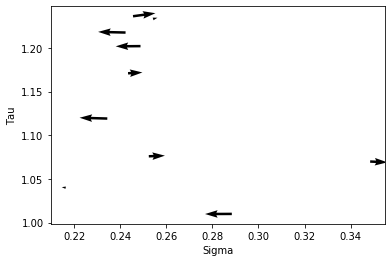

Data input success
Gradient:  [-0.51724385  0.02169233  0.85556312]
Likelihood:  795.875471015012
Hp:  [0.1955905  1.35628678 0.237912  ]  #  1
Gradient:  [ 0.93121052 -0.03512619 -0.36278521]
Likelihood:  776.415823725429
Hp:  [0.2205905  1.29628678 0.177912  ]  #  2
Gradient:  [ 0.61185575 -0.06154117 -0.78857163]
Likelihood:  798.4738143777817
Hp:  [0.2505905  1.22428678 0.105912  ]  #  3
Gradient:  [-0.41589577  0.02351429  0.90910824]
Likelihood:  791.5977064512674
Hp:  [0.2355905  1.26028678 0.141912  ]  #  4
Gradient:  [-0.83876828 -0.00970206  0.5444021 ]
Likelihood:  800.3505975951844
Hp:  [0.2175905  1.24228678 0.185112  ]  #  5
Gradient:  [ 0.75114028 -0.05141281 -0.65813753]
Likelihood:  797.5524499814626
Hp:  [0.2265905  1.22068678 0.163512  ]  #  6
Gradient:  [ 0.51030433 -0.08220434 -0.85605604]
Likelihood:  800.6406534162778
Hp:  [0.2373905  1.19476678 0.137592  ]  #  7
Gradient:  [-0.63279407  0.01767755  0.77411832]
Likelihood:  799.8495305243159
Hp:  [0.2319905  1.20

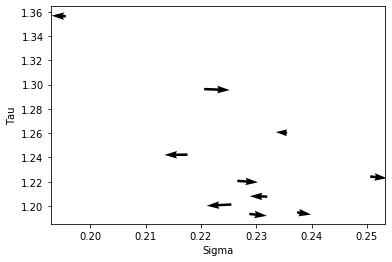

Data input success
Gradient:  [ 0.99451824 -0.0926742  -0.04842485]
Likelihood:  798.8945099865819
Hp:  [0.3487505  1.14347078 0.108328  ]  #  1
Gradient:  [-0.98864544 -0.00283236 -0.15024039]
Likelihood:  696.167739768195
Hp:  [0.2887505  1.08347078 0.048328  ]  #  2
Gradient:  [-0.144496    0.01664031  0.98936546]
Likelihood:  731.110538175007
Hp:  [0.2167505  1.11347078 0.078328  ]  #  3
Gradient:  [0.4820216  0.01945677 0.87594327]
Likelihood:  753.0121376523657
Hp:  [0.2527505  1.14947078 0.114328  ]  #  4
Gradient:  [-0.6404191   0.02450077  0.76763473]
Likelihood:  790.9997714233049
Hp:  [0.2347505  1.19267078 0.157528  ]  #  5
Gradient:  [-0.91079942 -0.04746048 -0.41011207]
Likelihood:  798.6674176835056
Hp:  [0.2131505  1.17107078 0.135928  ]  #  6
Gradient:  [0.82690032 0.0167004  0.56210048]
Likelihood:  789.4535841827023
Hp:  [0.2239505  1.18187078 0.146728  ]  #  7
Gradient:  [0.80747174 0.01210218 0.5897821 ]
Likelihood:  797.5070530753133
Hp:  [0.2369105  1.19483078 0.

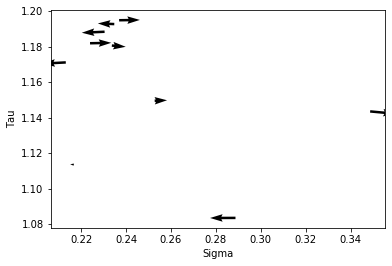

Data input success
Gradient:  [-0.92975567 -0.03841693 -0.36616736]
Likelihood:  800.0894627237687
Hp:  [0.1836705  1.13057478 0.106448  ]  #  1
Gradient:  [0.8161784  0.01602344 0.57757775]
Likelihood:  715.3063911160214
Hp:  [0.2086705  1.15557478 0.131448  ]  #  2
Gradient:  [0.81804121 0.01871943 0.57485491]
Likelihood:  785.6396451101872
Hp:  [0.2386705  1.18557478 0.161448  ]  #  3
Gradient:  [-0.87616528 -0.03038454 -0.48105216]
Likelihood:  798.8490416112419
Hp:  [0.2236705  1.17057478 0.146448  ]  #  4
Gradient:  [0.79040346 0.01705915 0.61234904]
Likelihood:  798.9560334500967
Hp:  [0.2311705  1.17807478 0.153948  ]  #  5
Gradient:  [-0.86327632 -0.07546172  0.49905864]
Likelihood:  800.2854576017999
Hp:  [0.2274205  1.17432478 0.162948  ]  #  6
Gradient:  [ 0.67377608 -0.07922947 -0.73467577]
Likelihood:  800.1685924875932
Hp:  [0.2292955  1.16982478 0.158448  ]  #  7
Gradient:  [ 0.57188781 -0.17469037 -0.80151582]
Likelihood:  800.3067285631683
Hp:  [0.2315455  1.16442478 

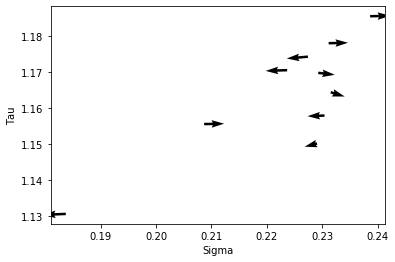

Data input success
Gradient:  [ 0.34038688 -0.05635981 -0.93859488]
Likelihood:  798.2659722113906
Hp:  [0.3490705  1.10016878 0.108988  ]  #  1
Gradient:  [-0.98818469 -0.00191603 -0.15325584]
Likelihood:  695.4618666902617
Hp:  [0.2890705  1.04016878 0.048988  ]  #  2
Gradient:  [-0.15043356  0.01807681  0.98845484]
Likelihood:  730.8169842486777
Hp:  [0.2170705  1.07016878 0.078988  ]  #  3
Gradient:  [0.46478292 0.02143665 0.88516513]
Likelihood:  755.5778080320748
Hp:  [0.2530705  1.10616878 0.114988  ]  #  4
Gradient:  [-0.70930804  0.02809419  0.70433857]
Likelihood:  791.696668831217
Hp:  [0.2350705  1.14936878 0.158188  ]  #  5
Gradient:  [-0.65537615 -0.04003184 -0.75424104]
Likelihood:  798.0192295100377
Hp:  [0.2134705  1.12776878 0.136588  ]  #  6
Gradient:  [0.87530981 0.01772297 0.48323765]
Likelihood:  790.4593187400138
Hp:  [0.2242705  1.13856878 0.147388  ]  #  7
Gradient:  [0.93982451 0.01067159 0.34149086]
Likelihood:  797.6005712094678
Hp:  [0.2372305  1.15152878 0

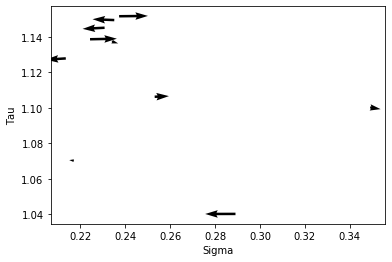

Data input success
Gradient:  [-0.52336598  0.02212399  0.85182075]
Likelihood:  801.2708100713131
Hp:  [0.1839905  1.25727278 0.266092  ]  #  1
Gradient:  [ 0.98460225 -0.02340976 -0.17323509]
Likelihood:  762.927969622969
Hp:  [0.2089905  1.19727278 0.206092  ]  #  2
Gradient:  [ 0.87469388 -0.03953444 -0.48306071]
Likelihood:  793.5962266504131
Hp:  [0.2389905  1.12527278 0.134092  ]  #  3
Gradient:  [-0.49281186  0.03068423  0.8695947 ]
Likelihood:  799.5939764970433
Hp:  [0.2239905  1.16127278 0.170092  ]  #  4
Gradient:  [ 0.77909845 -0.05775131 -0.62423584]
Likelihood:  801.2609999157397
Hp:  [0.2314905  1.14327278 0.152092  ]  #  5
Gradient:  [-0.48066914  0.00388849  0.87689341]
Likelihood:  801.6769986838729
Hp:  [0.2277405  1.15227278 0.161092  ]  #  6
Gradient:  [ 0.88292414 -0.10566849 -0.45747036]
Likelihood:  801.7691745468086
Hp:  [0.2296155  1.14777278 0.156592  ]  #  7
Gradient:  [-0.07645368 -0.0857687   0.99337735]
Likelihood:  801.7994759236066
Hp:  [0.228678   1.1

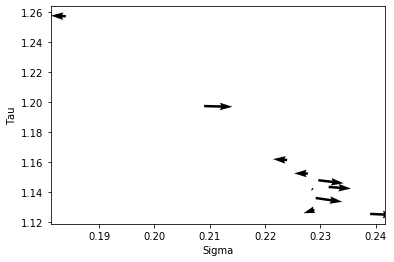

Data input success
Gradient:  [ 0.44739142 -0.0338763  -0.89369643]
Likelihood:  786.1586828377265
Hp:  [0.34891238 1.07811678 0.110192  ]  #  1
Gradient:  [-0.98158431 -0.00181062 -0.19102086]
Likelihood:  694.2623290026112
Hp:  [0.28891238 1.01811678 0.050192  ]  #  2
Gradient:  [-0.15735561  0.0197085   0.98734532]
Likelihood:  730.4765270986132
Hp:  [0.21691238 1.04811678 0.080192  ]  #  3
Gradient:  [0.49659127 0.02302313 0.86767911]
Likelihood:  754.8130693423387
Hp:  [0.25291238 1.08411678 0.116192  ]  #  4
Gradient:  [-0.91435482  0.03079244  0.40374137]
Likelihood:  788.0432260008891
Hp:  [0.23491238 1.12731678 0.159392  ]  #  5
Gradient:  [ 0.00547124 -0.0380576  -0.99926057]
Likelihood:  786.9059559634784
Hp:  [0.24391238 1.10571678 0.137792  ]  #  6
Gradient:  [-0.63431209 -0.01393227 -0.77295153]
Likelihood:  789.7860669788034
Hp:  [0.23941238 1.07979678 0.111872  ]  #  7
Gradient:  [0.1783213  0.04699775 0.98284929]
Likelihood:  789.2371356873685
Hp:  [0.24166238 1.092756

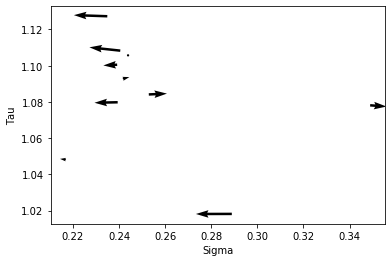

Data input success
Gradient:  [ 0.66047872  0.00414395 -0.75083333]
Likelihood:  779.4394269749647
Hp:  [0.35918738 1.22053278 0.082608  ]  #  1
Gradient:  [-0.99990825  0.00309196  0.0131884 ]
Likelihood:  680.5916297826275
Hp:  [0.29918738 1.36453278 0.107608  ]  #  2
Gradient:  [-0.96143945 -0.0074869  -0.27491478]
Likelihood:  748.9412028301547
Hp:  [0.22718738 1.29253278 0.095108  ]  #  3
Gradient:  [0.67010059 0.01675273 0.74208122]
Likelihood:  770.4632594398228
Hp:  [0.26318738 1.32853278 0.101358  ]  #  4
Gradient:  [-0.95847613  0.00643769  0.28510008]
Likelihood:  775.5363569368316
Hp:  [0.24518738 1.37173278 0.108858  ]  #  5
Gradient:  [-0.08904126  0.01125658  0.99596433]
Likelihood:  779.9748464199644
Hp:  [0.22358738 1.42357278 0.117858  ]  #  6
Gradient:  [9.81363427e-01 9.56028056e-04 1.92158555e-01]
Likelihood:  773.565247659944
Hp:  [0.23438738 1.48578078 0.128658  ]  #  7
Gradient:  [ 0.7133444  -0.03230599 -0.70006863]
Likelihood:  777.9804515838896
Hp:  [0.247347

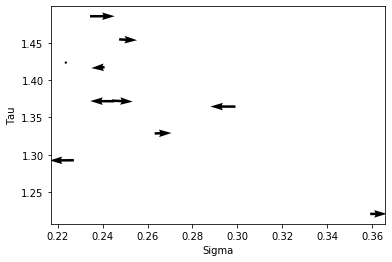

Data input success
Gradient:  [0.30193489 0.00873946 0.95328849]
Likelihood:  777.1565390019729
Hp:  [0.36410738 1.49256222 0.229002  ]  #  1
Gradient:  [-0.83717911 -0.03440402 -0.54584567]
Likelihood:  618.7301644129882
Hp:  [0.30410738 1.43256222 0.169002  ]  #  2
Gradient:  [-0.82197622 -0.0261405  -0.56892158]
Likelihood:  723.4116636357827
Hp:  [0.23210738 1.36056222 0.097002  ]  #  3
Gradient:  [0.62870062 0.01434215 0.77751516]
Likelihood:  771.2471035523077
Hp:  [0.26810738 1.39656222 0.133002  ]  #  4
Gradient:  [-0.81792047 -0.02193488 -0.57491301]
Likelihood:  767.5374613257443
Hp:  [0.25010738 1.37856222 0.115002  ]  #  5
Gradient:  [-0.97424736 -0.02265733 -0.22434065]
Likelihood:  777.011958121282
Hp:  [0.22850738 1.35696222 0.093402  ]  #  6
Gradient:  [0.63827828 0.01414798 0.7696757 ]
Likelihood:  767.5144127977276
Hp:  [0.23930738 1.36776222 0.104202  ]  #  7
Gradient:  [0.56214261 0.01374521 0.82692609]
Likelihood:  775.8830823032746
Hp:  [0.25226738 1.38072222 0.11

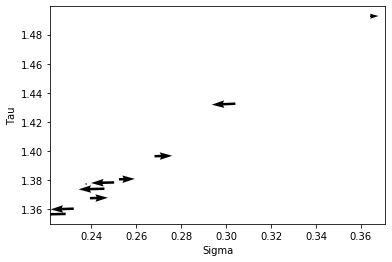

Data input success
Gradient:  [0.08059548 0.015046   0.99663333]
Likelihood:  792.8684658736104
Hp:  [0.35801138 1.49748222 0.233922  ]  #  1
Gradient:  [-0.84923324 -0.03409888 -0.52691571]
Likelihood:  635.5721907798455
Hp:  [0.29801138 1.43748222 0.173922  ]  #  2
Gradient:  [-0.87171812 -0.02484899 -0.4893772 ]
Likelihood:  742.3199207826734
Hp:  [0.22601138 1.36548222 0.101922  ]  #  3
Gradient:  [0.49523414 0.01607468 0.86861082]
Likelihood:  784.9728654656246
Hp:  [0.26201137 1.40148222 0.137922  ]  #  4
Gradient:  [-0.95670372 -0.01761967 -0.29052976]
Likelihood:  785.6565623428374
Hp:  [0.24401138 1.38348222 0.119922  ]  #  5
Gradient:  [-0.57477686  0.00550671  0.81829166]
Likelihood:  793.5070627065247
Hp:  [0.22241137 1.39248222 0.128922  ]  #  6
Gradient:  [0.77219181 0.00666964 0.63535449]
Likelihood:  792.2662877256397
Hp:  [0.23321137 1.40328222 0.139722  ]  #  7
Gradient:  [ 0.16907576 -0.10080233  0.98043474]
Likelihood:  795.8825052323474
Hp:  [0.24617137 1.39788222 

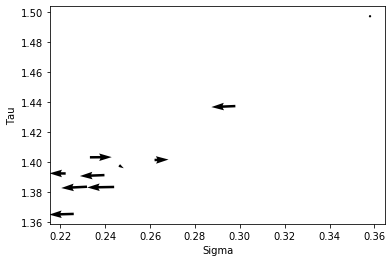

Data input success
Gradient:  [-0.12453454 -0.03567694 -0.99157365]
Likelihood:  803.7662107238639
Hp:  [0.18191537 1.33362622 0.088426  ]  #  1
Gradient:  [0.79512792 0.0119514  0.60632397]
Likelihood:  713.2184068478141
Hp:  [0.20691537 1.35862622 0.113426  ]  #  2
Gradient:  [0.8787957  0.01168132 0.4770552 ]
Likelihood:  789.1999102055389
Hp:  [0.23691537 1.38862622 0.143426  ]  #  3
Gradient:  [-0.45574552 -0.03220452 -0.88952734]
Likelihood:  802.2823782339306
Hp:  [0.22191537 1.37362622 0.128426  ]  #  4
Gradient:  [ 0.99956773 -0.00189508  0.02933878]
Likelihood:  802.9177387675943
Hp:  [0.22941537 1.35562622 0.135926  ]  #  5
Gradient:  [ 0.28890071 -0.03332738 -0.9567788 ]
Likelihood:  804.1563047359136
Hp:  [0.23841537 1.33402622 0.132176  ]  #  6
Gradient:  [-0.67258741 -0.02277336 -0.73966719]
Likelihood:  803.9968395030156
Hp:  [0.23391537 1.30810622 0.127676  ]  #  7
Gradient:  [-0.44293431 -0.01777368 -0.89637787]
Likelihood:  804.8752579587771
Hp:  [0.22851537 1.277002

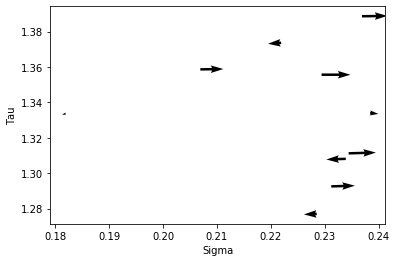

Data input success
Gradient:  [-0.207314   -0.02409451 -0.97797769]
Likelihood:  806.8686385263655
Hp:  [0.18445537 1.26121662 0.078216  ]  #  1
Gradient:  [0.7508477  0.01296083 0.6603482 ]
Likelihood:  709.8995407434952
Hp:  [0.20945537 1.28621662 0.103216  ]  #  2
Gradient:  [0.81523048 0.0154777  0.5789298 ]
Likelihood:  790.0290828735301
Hp:  [0.23945537 1.31621662 0.133216  ]  #  3
Gradient:  [-0.58916798 -0.02367789 -0.80766357]
Likelihood:  805.7288680294673
Hp:  [0.22445537 1.30121662 0.118216  ]  #  4
Gradient:  [0.91602624 0.01444709 0.40085808]
Likelihood:  805.2389160446671
Hp:  [0.23195537 1.30871662 0.125716  ]  #  5
Gradient:  [ 0.60328445 -0.01401487 -0.79740294]
Likelihood:  806.9813964497165
Hp:  [0.24095537 1.30496662 0.121966  ]  #  6
Gradient:  [-0.88205267 -0.0073687  -0.47109318]
Likelihood:  806.542596909796
Hp:  [0.23645537 1.30046662 0.117466  ]  #  7
Gradient:  [-0.70887816  0.05147516  0.70345012]
Likelihood:  807.1323673867298
Hp:  [0.23105537 1.30271662 0

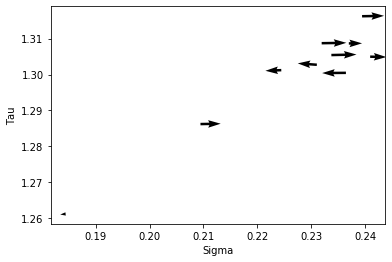

Data input success
Gradient:  [0.86276829 0.00238047 0.50559392]
Likelihood:  778.9042574976653
Hp:  [0.35699538 1.42865662 0.241066  ]  #  1
Gradient:  [-0.84121986 -0.03709488 -0.53941925]
Likelihood:  626.5309041190878
Hp:  [0.29699538 1.36865662 0.181066  ]  #  2
Gradient:  [-0.8285681  -0.02897997 -0.55913779]
Likelihood:  729.8977287028125
Hp:  [0.22499537 1.29665662 0.109066  ]  #  3
Gradient:  [0.79784707 0.01319213 0.60271555]
Likelihood:  771.6252888736477
Hp:  [0.26099537 1.33265662 0.145066  ]  #  4
Gradient:  [-0.79890364 -0.02674554 -0.60086409]
Likelihood:  771.693940228893
Hp:  [0.24299537 1.31465662 0.127066  ]  #  5
Gradient:  [-0.50688594 -0.07106157 -0.8590791 ]
Likelihood:  779.4153757940862
Hp:  [0.22139537 1.29305662 0.105466  ]  #  6
Gradient:  [0.78870782 0.01355757 0.61461871]
Likelihood:  767.4774547624032
Hp:  [0.23219537 1.30385662 0.116266  ]  #  7
Gradient:  [0.82315341 0.01049652 0.56772202]
Likelihood:  777.0891831479126
Hp:  [0.24515537 1.31681662 0.12

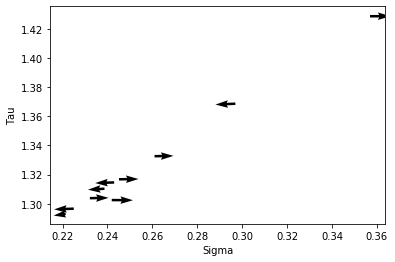

Data input success
Gradient:  [-0.63439567  0.01132085  0.77292559]
Likelihood:  799.1444789853409
Hp:  [0.19191537 1.42256062 0.245986  ]  #  1
Gradient:  [ 0.93646389 -0.03476858 -0.34903657]
Likelihood:  772.9605465084826
Hp:  [0.21691537 1.36256062 0.185986  ]  #  2
Gradient:  [ 0.62606219 -0.06002184 -0.77745965]
Likelihood:  797.9952781723086
Hp:  [0.24691537 1.29056062 0.113986  ]  #  3
Gradient:  [-0.50664914  0.01800496  0.86196431]
Likelihood:  795.8445130413718
Hp:  [0.23191537 1.32656062 0.149986  ]  #  4
Gradient:  [-0.97398682 -0.08440078 -0.21030022]
Likelihood:  801.9629578451867
Hp:  [0.21391537 1.30856062 0.131986  ]  #  5
Gradient:  [0.79027308 0.01276463 0.61262184]
Likelihood:  794.3576738542226
Hp:  [0.22291537 1.31756062 0.140986  ]  #  6
Gradient:  [0.7600894  0.00545162 0.64979564]
Likelihood:  800.6413982383467
Hp:  [0.23371538 1.32836062 0.151786  ]  #  7
Gradient:  [-0.91512121 -0.05467631 -0.39945422]
Likelihood:  801.7232374165517
Hp:  [0.22831538 1.322960

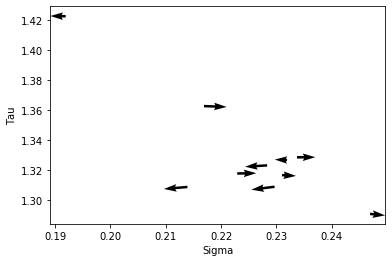

Data input success
Gradient:  [-0.14274643 -0.03691247 -0.98907074]
Likelihood:  804.9730325269855
Hp:  [0.17966538 1.25870462 0.102326  ]  #  1
Gradient:  [0.86412612 0.01271524 0.50311468]
Likelihood:  723.0845542894554
Hp:  [0.20466538 1.28370462 0.127326  ]  #  2
Gradient:  [0.94357174 0.01090603 0.33098857]
Likelihood:  792.6082685010279
Hp:  [0.23466538 1.31370462 0.157326  ]  #  3
Gradient:  [-0.4444385  -0.03497933 -0.89512617]
Likelihood:  803.2952508038711
Hp:  [0.21966537 1.29870462 0.142326  ]  #  4
Gradient:  [ 0.95998547 -0.00871536 -0.27991416]
Likelihood:  804.7134627922508
Hp:  [0.22716538 1.28070462 0.124326  ]  #  5
Gradient:  [0.78848456 0.02578665 0.61451374]
Likelihood:  806.5924119762834
Hp:  [0.23616538 1.28970462 0.133326  ]  #  6
Gradient:  [-0.75934221 -0.01521552 -0.65051356]
Likelihood:  806.6906757695365
Hp:  [0.23166538 1.28520462 0.128826  ]  #  7
Gradient:  [ 0.92126154  0.18171759 -0.34388354]
Likelihood:  807.1791851347746
Hp:  [0.23391538 1.28745462 

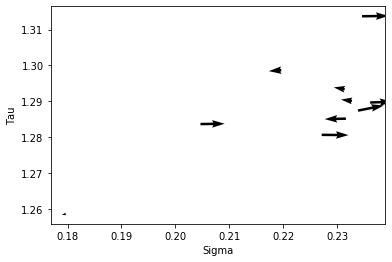

Data input success
Gradient:  [ 0.97771765 -0.00519873 -0.20985986]
Likelihood:  791.9956269575911
Hp:  [0.35144038 1.24339462 0.079366  ]  #  1
Gradient:  [-0.98296949  0.00709046  0.18363196]
Likelihood:  691.3013610917966
Hp:  [0.29144038 1.26839462 0.104366  ]  #  2
Gradient:  [-0.99988887  0.00260229  0.01467905]
Likelihood:  762.3115086764263
Hp:  [0.21944038 1.29839462 0.134366  ]  #  3
Gradient:  [ 9.99987656e-01 -3.06138158e-04  4.95921530e-03]
Likelihood:  787.4878215930562
Hp:  [0.25544037 1.28339462 0.170366  ]  #  4
Gradient:  [-0.67135812 -0.03278524 -0.7404076 ]
Likelihood:  777.7722476391706
Hp:  [0.23744038 1.26539462 0.152366  ]  #  5
Gradient:  [-0.28264667 -0.03615724 -0.95854239]
Likelihood:  789.4993906450358
Hp:  [0.21584038 1.24379462 0.130766  ]  #  6
Gradient:  [0.98125301 0.00774881 0.19256815]
Likelihood:  784.777808530886
Hp:  [0.22664038 1.25459462 0.141566  ]  #  7
Gradient:  [ 0.85581891 -0.01601323 -0.51702762]
Likelihood:  790.3492079950213
Hp:  [0.239

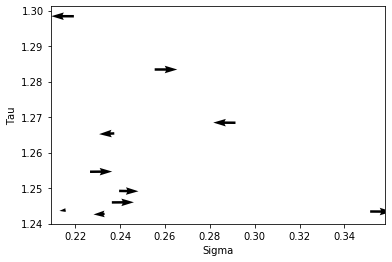

Data input success
Gradient:  [0.80402915 0.02470122 0.59407658]
Likelihood:  788.8578109038571
Hp:  [0.35636038 1.36595462 0.24191   ]  #  1
Gradient:  [-0.82475579 -0.03885847 -0.56415237]
Likelihood:  627.8608741930523
Hp:  [0.29636038 1.30595462 0.18191   ]  #  2
Gradient:  [-0.79612772 -0.02960944 -0.60440378]
Likelihood:  734.1735563532131
Hp:  [0.22436038 1.23395462 0.10991   ]  #  3
Gradient:  [0.73729473 0.01979519 0.67528115]
Likelihood:  782.8159264092216
Hp:  [0.26036037 1.26995462 0.14591   ]  #  4
Gradient:  [-0.76224395 -0.02402461 -0.64684386]
Likelihood:  779.1362169178443
Hp:  [0.24236037 1.25195462 0.12791   ]  #  5
Gradient:  [-0.70182325 -0.01903113 -0.71209687]
Likelihood:  788.7336399703618
Hp:  [0.22076037 1.23035462 0.10631   ]  #  6
Gradient:  [0.72998046 0.01911572 0.68320064]
Likelihood:  779.021573462267
Hp:  [0.23156037 1.24115462 0.11711   ]  #  7
Gradient:  [0.75799189 0.02153084 0.65190852]
Likelihood:  787.5455785527315
Hp:  [0.24452037 1.25411462 0.13

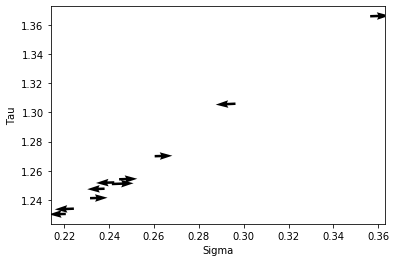

Data input success
Gradient:  [-0.67038215  0.01508475  0.74186267]
Likelihood:  795.5394351027692
Hp:  [0.19128038 1.37087462 0.24683   ]  #  1
Gradient:  [ 0.96390683 -0.02848022 -0.26471211]
Likelihood:  761.0542574060794
Hp:  [0.21628037 1.31087462 0.18683   ]  #  2
Gradient:  [ 0.74797297 -0.04699921 -0.66206307]
Likelihood:  789.6084996066271
Hp:  [0.24628037 1.23887462 0.11483   ]  #  3
Gradient:  [-0.50041657  0.02288332  0.8654823 ]
Likelihood:  793.0525351608281
Hp:  [0.23128037 1.27487462 0.15083   ]  #  4
Gradient:  [ 0.11639902 -0.07434534 -0.99041609]
Likelihood:  796.4234998804391
Hp:  [0.23878037 1.25687462 0.13283   ]  #  5
Gradient:  [-0.80831622  0.0023724   0.5887438 ]
Likelihood:  796.2396592064481
Hp:  [0.23503037 1.26587462 0.14183   ]  #  6
Gradient:  [-0.9198628  -0.06876809 -0.38616497]
Likelihood:  796.6727401539038
Hp:  [0.23053037 1.26137462 0.13733   ]  #  7
Gradient:  [0.75320295 0.00238707 0.65778386]
Likelihood:  796.4644891435124
Hp:  [0.23278037 1.263

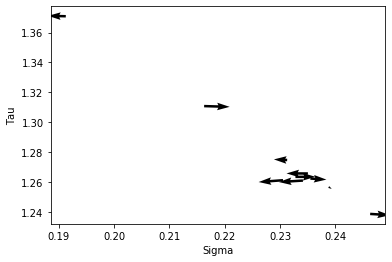

Data input success
Gradient:  [-0.22946326 -0.02618921 -0.97296492]
Likelihood:  804.6467925835851
Hp:  [0.18413038 1.21114962 0.09093   ]  #  1
Gradient:  [0.82052626 0.01388976 0.57144005]
Likelihood:  724.3019765172027
Hp:  [0.20913038 1.23614962 0.11593   ]  #  2
Gradient:  [0.91289522 0.01472291 0.40792836]
Likelihood:  793.1042344486427
Hp:  [0.23913038 1.26614962 0.14593   ]  #  3
Gradient:  [-0.47766267 -0.02684814 -0.87813299]
Likelihood:  802.8243243322465
Hp:  [0.22413037 1.25114962 0.13093   ]  #  4
Gradient:  [ 0.9670586   0.0016673  -0.25454838]
Likelihood:  804.7002774359645
Hp:  [0.23163037 1.25864962 0.11293   ]  #  5
Gradient:  [0.5342703  0.03641988 0.84452877]
Likelihood:  805.828953801766
Hp:  [0.24063038 1.26764962 0.12193   ]  #  6
Gradient:  [-0.90515754  0.00206287 -0.42507125]
Likelihood:  805.8752964039012
Hp:  [0.23613038 1.27844962 0.11743   ]  #  7
Gradient:  [-0.57235744  0.0719563   0.81684102]
Likelihood:  806.4329582162945
Hp:  [0.23073038 1.29140962 0

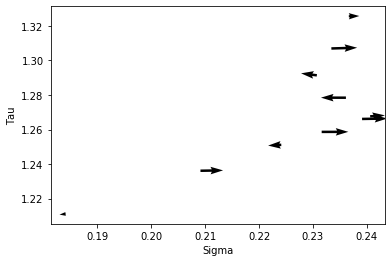

Data input success
Gradient:  [0.4741802  0.01188348 0.88034761]
Likelihood:  785.1466152727085
Hp:  [0.35667037 1.44562402 0.24103   ]  #  1
Gradient:  [-0.85759672 -0.03577041 -0.51307732]
Likelihood:  632.5482427288639
Hp:  [0.29667037 1.38562402 0.18103   ]  #  2
Gradient:  [-0.85973623 -0.02719051 -0.51001401]
Likelihood:  736.2387639479357
Hp:  [0.22467037 1.31362402 0.10903   ]  #  3
Gradient:  [0.69160112 0.01506488 0.72212253]
Likelihood:  777.6373539760981
Hp:  [0.26067037 1.34962402 0.14503   ]  #  4
Gradient:  [-0.88830887 -0.0230723  -0.45866657]
Likelihood:  778.1281378109667
Hp:  [0.24267037 1.33162402 0.12703   ]  #  5
Gradient:  [-0.77362526 -0.01611391  0.63343848]
Likelihood:  785.7358376916676
Hp:  [0.22107037 1.31002402 0.13603   ]  #  6
Gradient:  [0.93134128 0.00408758 0.36412459]
Likelihood:  781.3036857871454
Hp:  [0.23187037 1.32082402 0.14683   ]  #  7
Gradient:  [ 0.9568767  -0.05105951 -0.28597187]
Likelihood:  785.6474037211258
Hp:  [0.24483037 1.31542402 

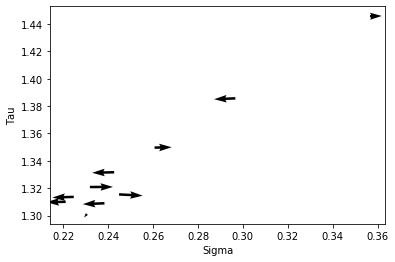

Data input success
Gradient:  [ 0.15272068 -0.02851725 -0.98785786]
Likelihood:  804.2955469868672
Hp:  [0.35057437 1.25116802 0.08819   ]  #  1
Gradient:  [-0.99996443  0.00343603 -0.0077031 ]
Likelihood:  700.769082680555
Hp:  [0.29057437 1.27616802 0.02819   ]  #  2
Gradient:  [-0.02347721  0.0081801   0.99969091]
Likelihood:  682.2653564805736
Hp:  [0.21857437 1.30616802 0.05819   ]  #  3
Gradient:  [0.30977973 0.01436497 0.95069983]
Likelihood:  753.1007154048053
Hp:  [0.25457437 1.34216802 0.09419   ]  #  4
Gradient:  [-0.65649385  0.02027199  0.75405893]
Likelihood:  799.7897199038637
Hp:  [0.23657437 1.38536802 0.13739   ]  #  5
Gradient:  [-0.31763729 -0.03026673 -0.94772912]
Likelihood:  803.6819072116253
Hp:  [0.21497437 1.36376802 0.11579   ]  #  6
Gradient:  [0.9492845  0.008596   0.31430088]
Likelihood:  798.8724409601525
Hp:  [0.22577437 1.37456802 0.12659   ]  #  7
Gradient:  [ 0.88811845 -0.01304756 -0.4594294 ]
Likelihood:  804.6967231780143
Hp:  [0.23873437 1.3691680

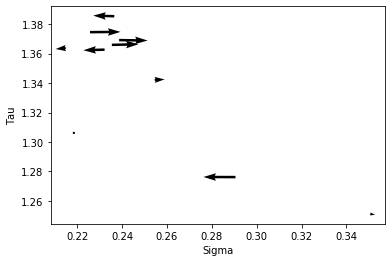

Data input success
Gradient:  [0.05712246 0.01701564 0.99822217]
Likelihood:  797.7884706313623
Hp:  [0.35549437 1.48592802 0.23795   ]  #  1
Gradient:  [-0.84514044 -0.03491045 -0.53340313]
Likelihood:  638.0290206147379
Hp:  [0.29549437 1.42592802 0.17795   ]  #  2
Gradient:  [-0.86880081 -0.025175   -0.49452135]
Likelihood:  746.1968168674355
Hp:  [0.22349437 1.35392802 0.10595   ]  #  3
Gradient:  [0.48874653 0.01729712 0.87225435]
Likelihood:  789.8791835617019
Hp:  [0.25949437 1.38992802 0.14195   ]  #  4
Gradient:  [-0.95808082 -0.01699273 -0.2859937 ]
Likelihood:  790.3261149179879
Hp:  [0.24149437 1.37192802 0.12395   ]  #  5
Gradient:  [-0.58563197  0.00795707  0.81053802]
Likelihood:  798.3972964486867
Hp:  [0.21989437 1.38092802 0.13295   ]  #  6
Gradient:  [0.75398037 0.00896178 0.65683581]
Likelihood:  797.4715486689239
Hp:  [0.23069437 1.39172802 0.14375   ]  #  7
Gradient:  [-0.08205195 -0.08655079  0.99286275]
Likelihood:  801.0014994917702
Hp:  [0.22529437 1.38632802 

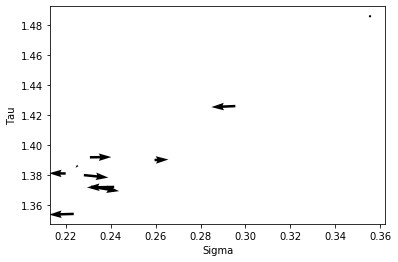

Data input success
Gradient:  [ 0.66443383 -0.03452847 -0.74654904]
Likelihood:  766.0577435641859
Hp:  [0.35123437 1.32207202 0.10347   ]  #  1
Gradient:  [-0.96018644 -0.00635766 -0.27928765]
Likelihood:  682.8548342611499
Hp:  [0.29123437 1.26207202 0.04347   ]  #  2
Gradient:  [-0.11469573  0.01258929  0.99332089]
Likelihood:  716.5065079723221
Hp:  [0.21923437 1.29207202 0.07347   ]  #  3
Gradient:  [0.55177143 0.01466477 0.83386644]
Likelihood:  732.5034915463523
Hp:  [0.25523437 1.32807202 0.10947   ]  #  4
Gradient:  [-0.90961262  0.01146713  0.41529915]
Likelihood:  769.1746413807786
Hp:  [0.23723437 1.37127202 0.15267   ]  #  5
Gradient:  [ 0.18089555 -0.04307966 -0.98255837]
Likelihood:  767.1118586422327
Hp:  [0.24623437 1.34967202 0.13107   ]  #  6
Gradient:  [-0.45269126 -0.03269491 -0.89106771]
Likelihood:  769.966877163002
Hp:  [0.24173437 1.32375202 0.10515   ]  #  7
Gradient:  [0.45406945 0.02241485 0.89068429]
Likelihood:  769.009763204756
Hp:  [0.24398437 1.33671202

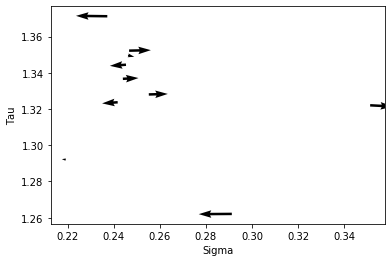

Data input success
Gradient:  [-0.82374935 -0.01486489 -0.56675924]
Likelihood:  807.8207951071827
Hp:  [0.19533438 1.29448802 0.075886  ]  #  1
Gradient:  [0.65914645 0.01395357 0.75188513]
Likelihood:  745.7498079779988
Hp:  [0.22033437 1.31948802 0.100886  ]  #  2
Gradient:  [0.67341535 0.01903168 0.73901933]
Likelihood:  803.4889812040898
Hp:  [0.25033437 1.34948802 0.130886  ]  #  3
Gradient:  [-0.80699283 -0.01711634 -0.59031314]
Likelihood:  804.9149513919035
Hp:  [0.23533437 1.33448802 0.115886  ]  #  4
Gradient:  [-0.56567732  0.04296517  0.82350663]
Likelihood:  810.3708268965402
Hp:  [0.21733437 1.34198802 0.123386  ]  #  5
Gradient:  [0.98099373 0.00647332 0.19393145]
Likelihood:  806.0344572894312
Hp:  [0.22633438 1.35098802 0.132386  ]  #  6
Gradient:  [ 0.72407699 -0.01973741 -0.68943669]
Likelihood:  809.2097774906186
Hp:  [0.23713438 1.34648802 0.127886  ]  #  7
Gradient:  [-0.59143898 -0.02150295 -0.806063  ]
Likelihood:  809.68382286757
Hp:  [0.23173438 1.34108802 0.

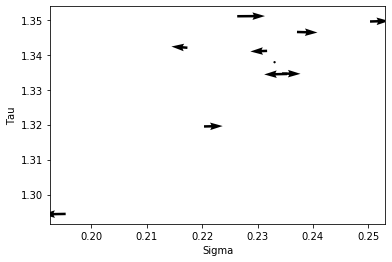

Data input success
Gradient:  [0.93754147 0.00159437 0.34786988]
Likelihood:  776.5202970843336
Hp:  [0.35308438 1.45784802 0.239246  ]  #  1
Gradient:  [-0.83787612 -0.03696165 -0.54460761]
Likelihood:  630.8653073602001
Hp:  [0.29308438 1.39784802 0.179246  ]  #  2
Gradient:  [-0.81369044 -0.02955766 -0.58054647]
Likelihood:  732.7902125770574
Hp:  [0.22108437 1.32584802 0.107246  ]  #  3
Gradient:  [0.84142528 0.01105867 0.54026032]
Likelihood:  766.9124665823008
Hp:  [0.25708437 1.36184802 0.143246  ]  #  4
Gradient:  [-0.7322859  -0.02978588 -0.68034562]
Likelihood:  772.2967543796692
Hp:  [0.23908437 1.34384802 0.125246  ]  #  5
Gradient:  [ 0.91071943 -0.03980051 -0.41110345]
Likelihood:  777.9503140411379
Hp:  [0.24808437 1.32224802 0.103646  ]  #  6
Gradient:  [-0.12341836  0.01867311  0.99217903]
Likelihood:  777.0345645665082
Hp:  [0.24358437 1.33304802 0.114446  ]  #  7
Gradient:  [0.26856173 0.00314209 0.96325735]
Likelihood:  778.1404723044533
Hp:  [0.24583437 1.34600802 

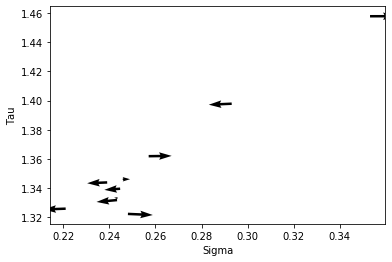

Data input success
Gradient:  [0.00137363 0.01391703 0.99990221]
Likelihood:  782.0405308580683
Hp:  [0.36335938 1.45175202 0.23315   ]  #  1
Gradient:  [-0.85165614 -0.0349058  -0.52293728]
Likelihood:  623.4908562116588
Hp:  [0.30335938 1.39175202 0.17315   ]  #  2
Gradient:  [-0.85510017 -0.02597744 -0.51781162]
Likelihood:  728.4262998933831
Hp:  [0.23135938 1.31975202 0.10115   ]  #  3
Gradient:  [0.55578229 0.01651113 0.8311639 ]
Likelihood:  776.266956953038
Hp:  [0.26735938 1.35575202 0.13715   ]  #  4
Gradient:  [-0.89268383 -0.02033511 -0.45022446]
Likelihood:  772.4577908650979
Hp:  [0.24935938 1.33775202 0.11915   ]  #  5
Gradient:  [-0.95783153 -0.00797123  0.28721982]
Likelihood:  781.8815539798861
Hp:  [0.22775938 1.31615202 0.12815   ]  #  6
Gradient:  [0.91908027 0.00251302 0.39406235]
Likelihood:  780.3892922410695
Hp:  [0.23855938 1.32695202 0.13895   ]  #  7
Gradient:  [-0.03898013 -0.086688   -0.99547262]
Likelihood:  782.7774577554308
Hp:  [0.23315938 1.32155202 0

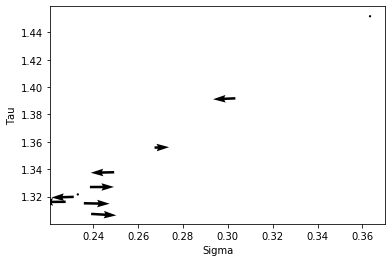

Data input success
Gradient:  [-0.50335173 -0.04241522 -0.86303997]
Likelihood:  792.3696051862245
Hp:  [0.18909938 1.25729602 0.0849    ]  #  1
Gradient:  [0.73710619 0.01313532 0.67564926]
Likelihood:  705.4973698161097
Hp:  [0.21409938 1.28229602 0.1099    ]  #  2
Gradient:  [0.79520513 0.01450314 0.60616702]
Likelihood:  778.3937926340174
Hp:  [0.24409938 1.31229602 0.1399    ]  #  3
Gradient:  [-0.67340559 -0.03249135 -0.73855888]
Likelihood:  790.9573505278801
Hp:  [0.22909937 1.29729602 0.1249    ]  #  4
Gradient:  [0.89652228 0.00637108 0.44295284]
Likelihood:  791.5451365106817
Hp:  [0.23659938 1.30479602 0.1324    ]  #  5
Gradient:  [-0.04588559 -0.05955909 -0.99716961]
Likelihood:  792.6490174395145
Hp:  [0.23284937 1.30104602 0.12865   ]  #  6
Gradient:  [ 0.989386   -0.01266397  0.14475832]
Likelihood:  792.481107175869
Hp:  [0.23472437 1.29654602 0.130525  ]  #  7
Gradient:  [ 0.89503751 -0.04542752 -0.44367127]
Likelihood:  792.6673336269357
Hp:  [0.23697437 1.29114602 0

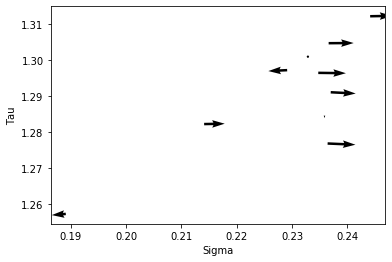

Data input success
Gradient:  [-0.10646054  0.01566219  0.99419357]
Likelihood:  797.2654205788072
Hp:  [0.18641188 1.39689002 0.249025  ]  #  1
Gradient:  [ 0.98931083 -0.02111684 -0.14428497]
Likelihood:  763.6673770590874
Hp:  [0.21141187 1.33689002 0.189025  ]  #  2
Gradient:  [ 0.93720125 -0.03504709 -0.34702379]
Likelihood:  792.2531295220417
Hp:  [0.24141187 1.26489002 0.117025  ]  #  3
Gradient:  [-0.20329937  0.02148971  0.97888077]
Likelihood:  794.8168120048633
Hp:  [0.22641187 1.30089002 0.153025  ]  #  4
Gradient:  [ 0.97716044 -0.04102866  0.20850451]
Likelihood:  798.4542891272245
Hp:  [0.23391187 1.28289002 0.196225  ]  #  5
Gradient:  [-0.56930839 -0.05593962 -0.8202187 ]
Likelihood:  793.1389437267469
Hp:  [0.23016187 1.26129002 0.174625  ]  #  6
Gradient:  [-0.38859932 -0.06902629 -0.91881768]
Likelihood:  797.6263544579782
Hp:  [0.22566187 1.23537002 0.148705  ]  #  7
Gradient:  [ 0.84140722 -0.00139874  0.54039979]
Likelihood:  798.2595874097652
Hp:  [0.22791187 1.

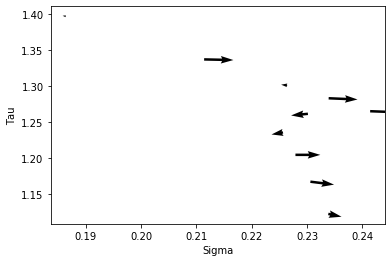

Data input success
Gradient:  [ 0.11868587 -0.03525375 -0.99230582]
Likelihood:  785.4395584493557
Hp:  [0.35385187 1.07215146 0.108425  ]  #  1
Gradient:  [-0.983347   -0.00117681 -0.18173412]
Likelihood:  686.6166812430699
Hp:  [0.29385187 1.01215146 0.048425  ]  #  2
Gradient:  [-0.16530985  0.01927384  0.98605333]
Likelihood:  723.5392397613117
Hp:  [0.22185187 1.04215146 0.078425  ]  #  3
Gradient:  [0.44239279 0.02375228 0.8965068 ]
Likelihood:  755.3356299610238
Hp:  [0.25785187 1.07815146 0.114425  ]  #  4
Gradient:  [-0.92315786  0.02722267  0.38345598]
Likelihood:  783.8809529404864
Hp:  [0.23985187 1.12135146 0.157625  ]  #  5
Gradient:  [-0.30253023 -0.0342267  -0.95252506]
Likelihood:  785.3373287952503
Hp:  [0.21825187 1.09975146 0.136025  ]  #  6
Gradient:  [0.99263012 0.01128975 0.12065645]
Likelihood:  781.5192621580588
Hp:  [0.22905187 1.11055146 0.146825  ]  #  7
Gradient:  [ 0.78565154 -0.01223381 -0.61854829]
Likelihood:  786.4773239894419
Hp:  [0.24201187 1.105151

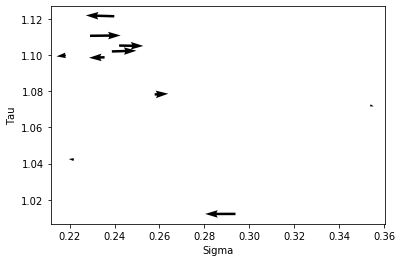

Data input success
Gradient:  [-0.28180948  0.04051463  0.95861462]
Likelihood:  798.0533687622078
Hp:  [0.18877187 1.22191146 0.247169  ]  #  1
Gradient:  [ 0.98053146 -0.02305429 -0.19500399]
Likelihood:  764.7785798326556
Hp:  [0.21377187 1.16191146 0.187169  ]  #  2
Gradient:  [ 0.88865666 -0.03353822 -0.4573451 ]
Likelihood:  793.7170529000394
Hp:  [0.24377187 1.08991146 0.115169  ]  #  3
Gradient:  [-0.28370719  0.03722427  0.95818818]
Likelihood:  795.0650215474765
Hp:  [0.22877187 1.12591146 0.151169  ]  #  4
Gradient:  [ 0.99985758 -0.00846944  0.01459782]
Likelihood:  799.7795092526404
Hp:  [0.23627187 1.10791146 0.194369  ]  #  5
Gradient:  [-0.58973996 -0.05004475 -0.80604113]
Likelihood:  793.6258090962334
Hp:  [0.23252187 1.08631146 0.172769  ]  #  6
Gradient:  [-0.47555593 -0.04610896 -0.87847625]
Likelihood:  798.4107285329324
Hp:  [0.22802187 1.06039146 0.146849  ]  #  7
Gradient:  [0.79317041 0.03732174 0.60785507]
Likelihood:  799.4791687174201
Hp:  [0.23027187 1.073

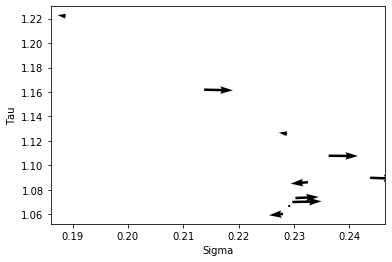

Data input success
Gradient:  [ 0.08617583 -0.02585071 -0.99594451]
Likelihood:  801.1527748359863
Hp:  [0.34970937 1.02011146 0.106569  ]  #  1
Gradient:  [-0.9903957   0.00294125 -0.1382306 ]
Likelihood:  698.264058676655
Hp:  [0.28970937 1.04511146 0.046569  ]  #  2
Gradient:  [-0.13688538  0.01804571  0.99042251]
Likelihood:  730.4253733382978
Hp:  [0.21770937 1.07511146 0.076569  ]  #  3
Gradient:  [0.4103861  0.02359508 0.91160656]
Likelihood:  769.7691202151603
Hp:  [0.25370937 1.11111146 0.112569  ]  #  4
Gradient:  [-0.93997269  0.02619947  0.34024245]
Likelihood:  799.0153515791459
Hp:  [0.23570937 1.15431146 0.155769  ]  #  5
Gradient:  [-0.33491296 -0.03237212 -0.94169281]
Likelihood:  800.385353804344
Hp:  [0.21410937 1.13271146 0.134169  ]  #  6
Gradient:  [0.99464691 0.01081744 0.10276434]
Likelihood:  797.3577402321342
Hp:  [0.22490937 1.14351146 0.144969  ]  #  7
Gradient:  [ 0.70911494 -0.01407886 -0.70495233]
Likelihood:  802.0185568378604
Hp:  [0.23786937 1.13811146

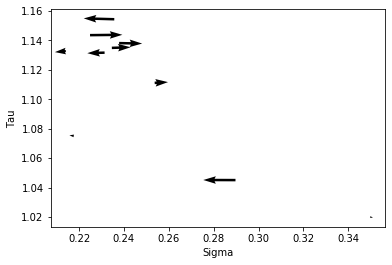

Data input success
Gradient:  [0.520697   0.02963559 0.85322703]
Likelihood:  785.8669452790493
Hp:  [0.35462937 1.25487146 0.245313  ]  #  1
Gradient:  [-0.87309143 -0.03798577 -0.48607452]
Likelihood:  639.9099262896773
Hp:  [0.29462937 1.19487146 0.185313  ]  #  2
Gradient:  [-0.88137925 -0.02744566 -0.47161144]
Likelihood:  741.3858382447497
Hp:  [0.22262937 1.12287146 0.113313  ]  #  3
Gradient:  [0.70306777 0.02280827 0.71075698]
Likelihood:  777.0535532180761
Hp:  [0.25862937 1.15887146 0.149313  ]  #  4
Gradient:  [-0.92707419 -0.01810451 -0.37444047]
Likelihood:  780.9991090343133
Hp:  [0.24062937 1.14087146 0.131313  ]  #  5
Gradient:  [-0.21455518  0.03324706  0.97614584]
Likelihood:  787.0495023818864
Hp:  [0.21902937 1.14987146 0.140313  ]  #  6
Gradient:  [0.91079497 0.01265603 0.41266494]
Likelihood:  781.5905961777119
Hp:  [0.22982937 1.16067146 0.151113  ]  #  7
Gradient:  [ 0.98336195 -0.00814505  0.18147431]
Likelihood:  787.0887568059084
Hp:  [0.24278937 1.15527146 

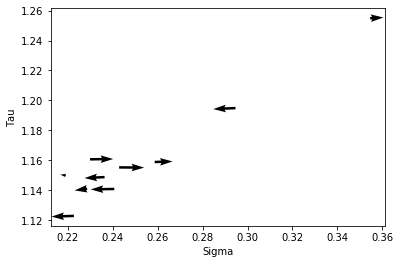

Data input success
Gradient:  [ 0.64783109 -0.02096017 -0.7614956 ]
Likelihood:  788.6222422286037
Hp:  [0.34853337 1.09101546 0.099817  ]  #  1
Gradient:  [-9.88918892e-01  8.49284485e-04 -1.48454385e-01]
Likelihood:  698.3642230092036
Hp:  [0.28853337 1.11601546 0.039817  ]  #  2
Gradient:  [-0.07262789  0.01343349  0.99726864]
Likelihood:  715.6820295591646
Hp:  [0.21653337 1.14601546 0.069817  ]  #  3
Gradient:  [0.46987846 0.01850562 0.88253712]
Likelihood:  750.5563734307405
Hp:  [0.25253337 1.18201546 0.105817  ]  #  4
Gradient:  [-0.82152628  0.02887597  0.56943898]
Likelihood:  789.8423778899886
Hp:  [0.23453337 1.22521546 0.149017  ]  #  5
Gradient:  [ 0.06618681 -0.03503742 -0.9971919 ]
Likelihood:  789.0751537433838
Hp:  [0.24353337 1.20361546 0.127417  ]  #  6
Gradient:  [-0.62949335 -0.01273168 -0.77690156]
Likelihood:  791.6529176892496
Hp:  [0.23903337 1.17769546 0.101497  ]  #  7
Gradient:  [0.27436355 0.03468946 0.96100015]
Likelihood:  790.1611756049718
Hp:  [0.24128

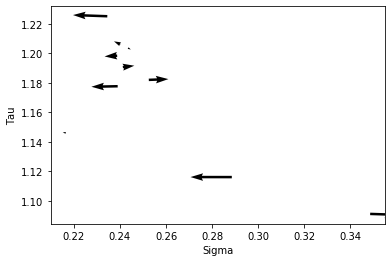

Data input success
Gradient:  [-0.97344904  0.04348083  0.22473626]
Likelihood:  804.67441825784
Hp:  [0.18880837 1.31843146 0.242233  ]  #  1
Gradient:  [ 0.95206481 -0.02311602 -0.3050217 ]
Likelihood:  753.1346772852235
Hp:  [0.21380837 1.25843146 0.182233  ]  #  2
Gradient:  [ 0.67537462 -0.03295498 -0.73673814]
Likelihood:  791.2534730503484
Hp:  [0.24380837 1.18643146 0.110233  ]  #  3
Gradient:  [-0.58840496  0.03952522  0.80759976]
Likelihood:  803.0632409086883
Hp:  [0.22880837 1.22243146 0.146233  ]  #  4
Gradient:  [ 0.26516081 -0.02710759 -0.96382308]
Likelihood:  803.09868473195
Hp:  [0.23630837 1.20443146 0.128233  ]  #  5
Gradient:  [-0.70643765  0.0149935  -0.70761645]
Likelihood:  804.842745202287
Hp:  [0.23255837 1.21343146 0.106633  ]  #  6
Gradient:  [0.34778838 0.03383177 0.93696246]
Likelihood:  802.7329377454568
Hp:  [0.23443337 1.22423146 0.117433  ]  #  7
Gradient:  [0.25917253 0.04982919 0.96454479]
Likelihood:  804.6963172705617
Hp:  [0.23668337 1.23719146 0.

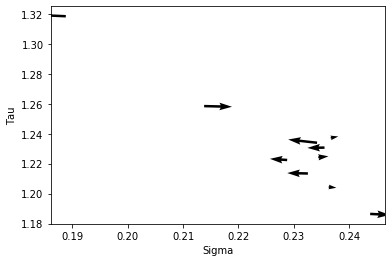

Data input success
Gradient:  [0.00441249 0.0240426  0.9997012 ]
Likelihood:  800.613477259161
Hp:  [0.35420837 1.35395146 0.247153  ]  #  1
Gradient:  [-0.84666438 -0.03852886 -0.53073058]
Likelihood:  638.4993245444853
Hp:  [0.29420837 1.29395146 0.187153  ]  #  2
Gradient:  [-0.86423694 -0.02782531 -0.50231491]
Likelihood:  746.7931652575838
Hp:  [0.22220837 1.22195146 0.115153  ]  #  3
Gradient:  [0.53064172 0.02212714 0.84730735]
Likelihood:  793.9134336395717
Hp:  [0.25820837 1.25795146 0.151153  ]  #  4
Gradient:  [-0.93661833 -0.01862051 -0.34985624]
Likelihood:  791.7528042251415
Hp:  [0.24020837 1.23995146 0.133153  ]  #  5
Gradient:  [-0.78286877  0.00932179  0.62211703]
Likelihood:  800.7700439827112
Hp:  [0.21860837 1.24895146 0.142153  ]  #  6
Gradient:  [0.83402747 0.01052129 0.55162259]
Likelihood:  799.8042258008519
Hp:  [0.22940837 1.25975146 0.152953  ]  #  7
Gradient:  [-0.54872101 -0.21025587 -0.80913393]
Likelihood:  802.6852081500289
Hp:  [0.22400837 1.25435146 0

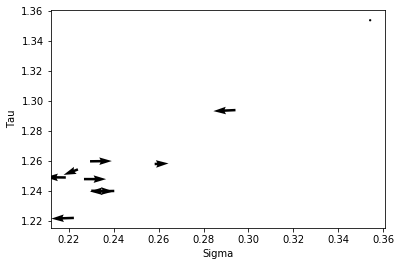

Data input success
Gradient:  [ 0.18565968 -0.20897369 -0.96013566]
Likelihood:  798.2765608895076
Hp:  [0.34994837 1.19009546 0.103493  ]  #  1
Gradient:  [-0.98990533 -0.00300686 -0.14169826]
Likelihood:  693.973621368799
Hp:  [0.28994837 1.13009546 0.043493  ]  #  2
Gradient:  [-0.10806554  0.01418092  0.99404262]
Likelihood:  722.3018343429552
Hp:  [0.21794837 1.16009546 0.073493  ]  #  3
Gradient:  [0.44694856 0.01741792 0.89439007]
Likelihood:  749.5160177336419
Hp:  [0.25394837 1.19609546 0.109493  ]  #  4
Gradient:  [-0.61359689  0.02118097  0.7893353 ]
Likelihood:  789.3545762790793
Hp:  [0.23594837 1.23929546 0.152693  ]  #  5
Gradient:  [-0.89815665 -0.04164942 -0.43769848]
Likelihood:  797.8056377822837
Hp:  [0.21434837 1.21769546 0.131093  ]  #  6
Gradient:  [0.79465743 0.01617303 0.60684265]
Likelihood:  789.7162809558988
Hp:  [0.22514837 1.22849546 0.141893  ]  #  7
Gradient:  [0.75885286 0.01019441 0.65118231]
Likelihood:  797.2137634288943
Hp:  [0.23810837 1.24145546 0

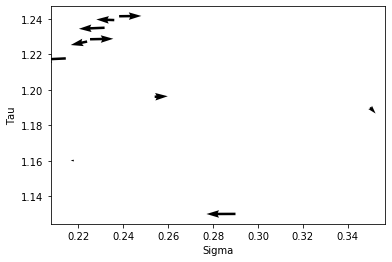

Data input success
Gradient:  [ 0.90877533 -0.00404879  0.41726612]
Likelihood:  798.8650651973363
Hp:  [0.34385237 1.17719946 0.271613  ]  #  1
Gradient:  [-0.85866859 -0.0452992  -0.51052545]
Likelihood:  648.7947638693416
Hp:  [0.28385237 1.11719946 0.211613  ]  #  2
Gradient:  [-0.85677727 -0.03449957 -0.51453133]
Likelihood:  752.8634711072402
Hp:  [0.21185237 1.04519946 0.139613  ]  #  3
Gradient:  [0.82546123 0.02410957 0.56394368]
Likelihood:  789.4774838877886
Hp:  [0.24785237 1.08119946 0.175613  ]  #  4
Gradient:  [-0.8667579  -0.02735133 -0.49797857]
Likelihood:  793.6142514581993
Hp:  [0.22985237 1.06319946 0.157613  ]  #  5
Gradient:  [0.44870948 0.04192009 0.89269396]
Likelihood:  799.7817662876671
Hp:  [0.23885237 1.07219946 0.166613  ]  #  6
Gradient:  [-0.88617574 -0.02417337 -0.46271828]
Likelihood:  798.3363113024275
Hp:  [0.23435237 1.06769946 0.162113  ]  #  7
Gradient:  [-0.92813495 -0.01923149 -0.37174677]
Likelihood:  799.5137172437708
Hp:  [0.22895237 1.062299

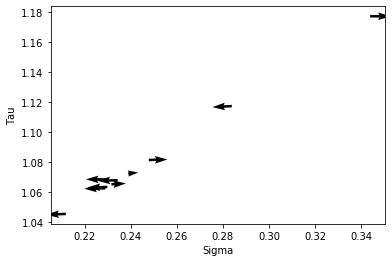

Data input success
Gradient:  [-0.1519271  -0.02828208 -0.98798698]
Likelihood:  806.9026741795618
Hp:  [0.18030237 1.01823946 0.112653  ]  #  1
Gradient:  [0.91585559 0.01656253 0.40116607]
Likelihood:  735.0006067564111
Hp:  [0.20530237 1.04323946 0.137653  ]  #  2
Gradient:  [0.98807317 0.01547699 0.15320536]
Likelihood:  797.2876391627354
Hp:  [0.23530237 1.07323946 0.167653  ]  #  3
Gradient:  [-0.41245845 -0.03096643 -0.91044995]
Likelihood:  804.9574522514432
Hp:  [0.22030237 1.05823946 0.152653  ]  #  4
Gradient:  [ 0.80510229 -0.00375778 -0.59312409]
Likelihood:  807.4143539906112
Hp:  [0.22780237 1.04023946 0.134653  ]  #  5
Gradient:  [ 0.93729778  0.05355205 -0.34439085]
Likelihood:  810.5026608679797
Hp:  [0.23680237 1.04923946 0.113053  ]  #  6
Gradient:  [-0.11061909  0.06610698  0.99166188]
Likelihood:  809.8396591670207
Hp:  [0.23230237 1.06003946 0.123853  ]  #  7
Gradient:  [0.44564981 0.12523454 0.88640429]
Likelihood:  810.9446786700908
Hp:  [0.23455237 1.07299946 

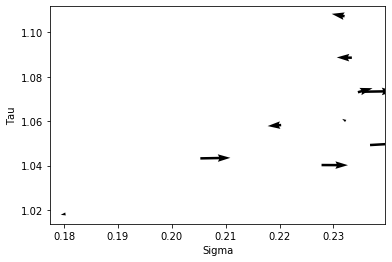

Data input success
Gradient:  [0.22733084 0.08182478 0.97037384]
Likelihood:  810.4521586485264
Hp:  [0.35207737 1.22721386 0.242557  ]  #  1
Gradient:  [-0.83047903 -0.03932801 -0.55565987]
Likelihood:  644.0622459168887
Hp:  [0.29207737 1.16721386 0.182557  ]  #  2
Gradient:  [-0.81864247 -0.02724978 -0.57365665]
Likelihood:  753.5097793134382
Hp:  [0.22007737 1.09521386 0.110557  ]  #  3
Gradient:  [0.65371188 0.03347934 0.75600258]
Likelihood:  804.4733156613895
Hp:  [0.25607737 1.13121386 0.146557  ]  #  4
Gradient:  [-0.8314465  -0.01511976 -0.55539906]
Likelihood:  800.116463553314
Hp:  [0.23807737 1.11321386 0.128557  ]  #  5
Gradient:  [-0.98265724  0.0350837  -0.18208209]
Likelihood:  810.2285908124392
Hp:  [0.21647737 1.12221386 0.106957  ]  #  6
Gradient:  [0.67633388 0.02832485 0.73605039]
Likelihood:  801.1643149090527
Hp:  [0.22727737 1.13301386 0.117757  ]  #  7
Gradient:  [0.58317595 0.04404002 0.81115121]
Likelihood:  809.4664776091985
Hp:  [0.24023737 1.14597386 0.13

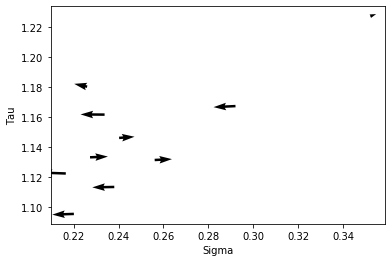

Data input success
Gradient:  [0.92706146 0.01960847 0.37439626]
Likelihood:  775.2804091848961
Hp:  [0.34598137 1.30018826 0.247477  ]  #  1
Gradient:  [-0.83686157 -0.03922427 -0.54600747]
Likelihood:  640.3218184780583
Hp:  [0.28598137 1.24018826 0.187477  ]  #  2
Gradient:  [-0.80442617 -0.02975841 -0.59330681]
Likelihood:  739.8172597925777
Hp:  [0.21398137 1.16818826 0.115477  ]  #  3
Gradient:  [0.86473985 0.018651   0.50187361]
Likelihood:  762.3016948404032
Hp:  [0.24998137 1.20418826 0.151477  ]  #  4
Gradient:  [-0.67811232 -0.02416513 -0.7345609 ]
Likelihood:  775.6915859586903
Hp:  [0.23198137 1.18618826 0.133477  ]  #  5
Gradient:  [0.99116424 0.01803706 0.13140822]
Likelihood:  778.1047511617664
Hp:  [0.24098137 1.19518826 0.142477  ]  #  6
Gradient:  [-0.29188316 -0.01947755 -0.95625564]
Likelihood:  778.6962246742769
Hp:  [0.23648137 1.19068826 0.137977  ]  #  7
Gradient:  [ 0.78508355  0.00413372 -0.61937608]
Likelihood:  778.9008148950594
Hp:  [0.23873137 1.19293826 

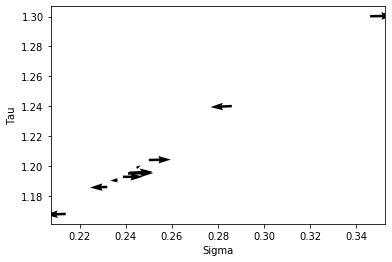

Data input success
Gradient:  [-0.39549091 -0.02555935 -0.91811419]
Likelihood:  778.5062142171399
Hp:  [0.19467137 1.14887826 0.079337  ]  #  1
Gradient:  [0.7526309  0.01398272 0.65829417]
Likelihood:  693.1614281037455
Hp:  [0.21967137 1.17387826 0.104337  ]  #  2
Gradient:  [0.81535356 0.01715109 0.57870926]
Likelihood:  763.933685573128
Hp:  [0.24967137 1.20387826 0.134337  ]  #  3
Gradient:  [-0.67097364 -0.02476349 -0.74106757]
Likelihood:  777.377549047905
Hp:  [0.23467137 1.18887826 0.119337  ]  #  4
Gradient:  [0.90909909 0.01681878 0.41624029]
Likelihood:  777.2497494442508
Hp:  [0.24217137 1.19637826 0.126837  ]  #  5
Gradient:  [ 0.42290441 -0.01746785 -0.90600592]
Likelihood:  778.6592268887084
Hp:  [0.25117137 1.19262826 0.123087  ]  #  6
Gradient:  [-0.91335008 -0.0072907  -0.40710992]
Likelihood:  778.019613582345
Hp:  [0.24667137 1.18812826 0.118587  ]  #  7
Gradient:  [-0.88874905  0.03757852  0.45685116]
Likelihood:  778.6741369792733
Hp:  [0.24127137 1.19037826 0.1

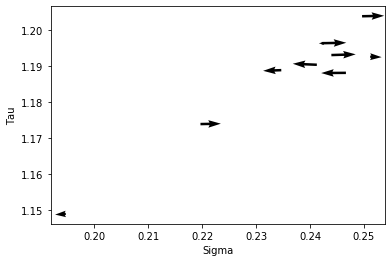

Data input success
Gradient:  [-0.89747647  0.03154507  0.43993283]
Likelihood:  795.8723906664843
Hp:  [0.19262137 1.31631826 0.242187  ]  #  1
Gradient:  [ 0.94772851 -0.02694392 -0.31793821]
Likelihood:  752.7046589931733
Hp:  [0.21762137 1.25631826 0.182187  ]  #  2
Gradient:  [ 0.6225193  -0.03865204 -0.78164937]
Likelihood:  785.7948650512926
Hp:  [0.24762137 1.18431826 0.110187  ]  #  3
Gradient:  [-0.57691089  0.03376839  0.81610877]
Likelihood:  793.5779148319479
Hp:  [0.23262137 1.22031826 0.146187  ]  #  4
Gradient:  [ 0.03236418 -0.03130568 -0.99898574]
Likelihood:  795.5052018098883
Hp:  [0.24012137 1.20231826 0.128187  ]  #  5
Gradient:  [-0.98872211  0.01698426 -0.14879555]
Likelihood:  796.3513147625064
Hp:  [0.23637137 1.21131826 0.106587  ]  #  6
Gradient:  [0.18705871 0.03240111 0.98181424]
Likelihood:  793.7893734570239
Hp:  [0.23824637 1.22211826 0.117387  ]  #  7
Gradient:  [-0.09873926  0.0413909   0.99425216]
Likelihood:  796.0319497586287
Hp:  [0.23730887 1.235

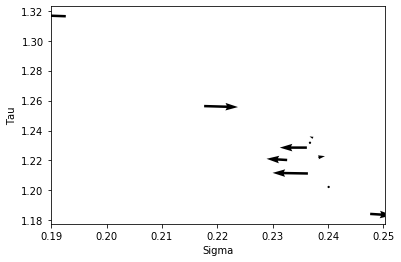

Data input success
Gradient:  [ 0.27842563 -0.02741381 -0.96006648]
Likelihood:  793.4122108861535
Hp:  [0.35674637 1.18183826 0.077107  ]  #  1
Gradient:  [-0.98474496  0.00784123  0.17382714]
Likelihood:  690.3763425380844
Hp:  [0.29674637 1.20683826 0.102107  ]  #  2
Gradient:  [-9.88224213e-01 -8.50598502e-04 -1.53010397e-01]
Likelihood:  762.3475792480314
Hp:  [0.22474637 1.19433826 0.089607  ]  #  3
Gradient:  [0.60317008 0.02060094 0.79734651]
Likelihood:  783.2564950171919
Hp:  [0.26074637 1.20058826 0.095857  ]  #  4
Gradient:  [-0.83799737  0.02027748  0.54529737]
Likelihood:  788.950502734331
Hp:  [0.24274637 1.20808826 0.103357  ]  #  5
Gradient:  [0.00483565 0.0373607  0.99929015]
Likelihood:  793.8977995720752
Hp:  [0.25174637 1.21708826 0.112357  ]  #  6
Gradient:  [-0.96044962 -0.00101234 -0.27845198]
Likelihood:  792.8756582597125
Hp:  [0.24724637 1.21258826 0.107857  ]  #  7
Gradient:  [-0.92470305  0.02466917  0.37988905]
Likelihood:  793.8931632530846
Hp:  [0.241846

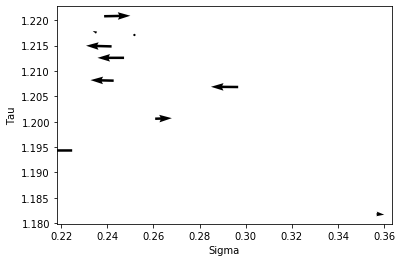

Data input success
Gradient:  [-0.05017887  0.02575914  0.99840801]
Likelihood:  796.5702858189379
Hp:  [0.18860637 1.34077826 0.236047  ]  #  1
Gradient:  [ 0.98391522 -0.02109432 -0.17738624]
Likelihood:  771.1116015199245
Hp:  [0.21360637 1.28077826 0.176047  ]  #  2
Gradient:  [ 0.97699882 -0.0265074  -0.2115908 ]
Likelihood:  797.5955994017661
Hp:  [0.24360637 1.20877826 0.104047  ]  #  3
Gradient:  [-0.09412835  0.02541266  0.99523568]
Likelihood:  792.2652696569263
Hp:  [0.22860637 1.24477826 0.140047  ]  #  4
Gradient:  [0.45976253 0.01288909 0.88794836]
Likelihood:  800.7471567113876
Hp:  [0.23610637 1.28797826 0.183247  ]  #  5
Gradient:  [-0.65617884 -0.04784953 -0.75308682]
Likelihood:  796.9861381090681
Hp:  [0.23235637 1.26637826 0.161647  ]  #  6
Gradient:  [-0.70298484 -0.05856754 -0.70878922]
Likelihood:  800.9497372173356
Hp:  [0.22785637 1.24045826 0.135727  ]  #  7
Gradient:  [0.48563171 0.0178253  0.87398175]
Likelihood:  800.0791971211247
Hp:  [0.23010637 1.253418

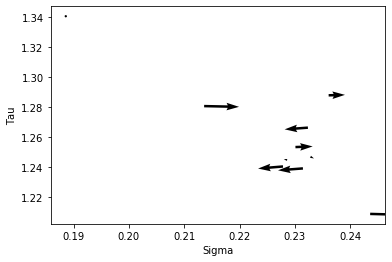

Data input success
Gradient:  [-0.78585463 -0.06474959 -0.61501218]
Likelihood:  802.5003479979259
Hp:  [0.18145637 1.18916226 0.106463  ]  #  1
Gradient:  [0.81458959 0.01455939 0.57985501]
Likelihood:  714.4913440254498
Hp:  [0.20645637 1.21416226 0.131463  ]  #  2
Gradient:  [0.82518943 0.0155719  0.56464142]
Likelihood:  787.4360319512066
Hp:  [0.23645637 1.24416226 0.161463  ]  #  3
Gradient:  [-0.81256627 -0.03939878 -0.58153571]
Likelihood:  801.2551309118327
Hp:  [0.22145637 1.22916226 0.146463  ]  #  4
Gradient:  [0.83722614 0.00756139 0.54680456]
Likelihood:  801.2698594427015
Hp:  [0.22895637 1.23666226 0.153963  ]  #  5
Gradient:  [-0.27791567 -0.37880681 -0.88276174]
Likelihood:  802.6865018776721
Hp:  [0.22520637 1.23291226 0.150213  ]  #  6
Gradient:  [ 0.85151523 -0.00805407  0.52426802]
Likelihood:  802.3677815995704
Hp:  [0.22708137 1.22841226 0.152088  ]  #  7
Gradient:  [ 0.86290875 -0.03784177  0.50394096]
Likelihood:  802.6301977593733
Hp:  [0.22933137 1.22301226 

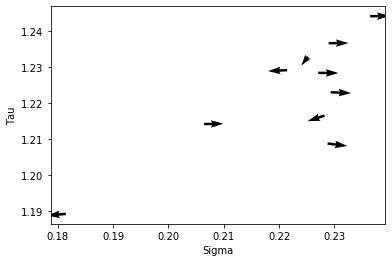

802.7493015338631
Data input success
Gradient:  [ 0.80124112 -0.0585013  -0.59547482]
Likelihood:  797.8334127665152
Hp:  [0.34876887 1.15875626 0.1037755 ]  #  1
Gradient:  [-0.99207212 -0.00155312 -0.12566027]
Likelihood:  696.0172260687048
Hp:  [0.28876887 1.09875626 0.0437755 ]  #  2
Gradient:  [-0.10320763  0.01487864  0.99454855]
Likelihood:  722.7794055955793
Hp:  [0.21676887 1.12875626 0.0737755 ]  #  3
Gradient:  [0.45369724 0.018611   0.89096153]
Likelihood:  748.6167578449372
Hp:  [0.25276887 1.16475626 0.1097755 ]  #  4
Gradient:  [-0.5794592   0.02599634  0.81458654]
Likelihood:  790.3428006634393
Hp:  [0.23476887 1.20795626 0.1529755 ]  #  5
Gradient:  [-0.72423547 -0.04583424 -0.68802776]
Likelihood:  797.7409306375847
Hp:  [0.21316887 1.18635626 0.1313755 ]  #  6
Gradient:  [0.84069497 0.01670204 0.54125134]
Likelihood:  788.484461392793
Hp:  [0.22396887 1.19715626 0.1421755 ]  #  7
Gradient:  [0.87014178 0.01186256 0.49265867]
Likelihood:  796.608830579812
Hp:  [0.2369

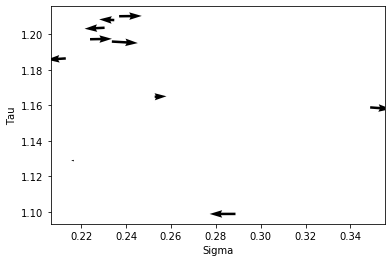

Data input success
Gradient:  [0.14026356 0.01368641 0.9900196 ]
Likelihood:  796.4643784596124
Hp:  [0.35368887 1.31586026 0.2608795 ]  #  1
Gradient:  [-0.86000695 -0.04066764 -0.5086592 ]
Likelihood:  636.2836928517747
Hp:  [0.29368887 1.25586026 0.2008795 ]  #  2
Gradient:  [-0.8664948  -0.03101984 -0.49822138]
Likelihood:  742.2269342824377
Hp:  [0.22168887 1.18386026 0.1288795 ]  #  3
Gradient:  [0.71630549 0.01961888 0.69751097]
Likelihood:  791.1926141699241
Hp:  [0.25768887 1.21986026 0.1648795 ]  #  4
Gradient:  [-0.89810166 -0.02538663 -0.43905457]
Likelihood:  786.6027438910968
Hp:  [0.23968887 1.20186026 0.1468795 ]  #  5
Gradient:  [-0.99916923 -0.01919196  0.03595165]
Likelihood:  796.1866564970148
Hp:  [0.21808887 1.18026026 0.1558795 ]  #  6
Gradient:  [0.94471803 0.00365629 0.32786351]
Likelihood:  793.8472805663085
Hp:  [0.22888887 1.19106026 0.1666795 ]  #  7
Gradient:  [ 0.31144564 -0.10132233 -0.94484676]
Likelihood:  796.6957842742145
Hp:  [0.24184887 1.18566026 

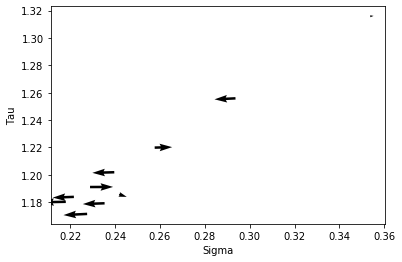

Data input success
Gradient:  [ 0.74472689 -0.02344297 -0.66695748]
Likelihood:  782.5414414303607
Hp:  [0.34759287 1.12140426 0.0970235 ]  #  1
Gradient:  [-9.87952045e-01 -8.62666394e-05 -1.54760298e-01]
Likelihood:  699.0450688630016
Hp:  [0.28759287 1.06140426 0.0370235 ]  #  2
Gradient:  [-0.04824896  0.01306029  0.99874995]
Likelihood:  705.889109555061
Hp:  [0.21559287 1.09140426 0.0670235 ]  #  3
Gradient:  [0.47831326 0.01841108 0.87799627]
Likelihood:  740.2883535863431
Hp:  [0.25159287 1.12740426 0.1030235 ]  #  4
Gradient:  [-0.61735156  0.03845551  0.78574692]
Likelihood:  786.2792244119861
Hp:  [0.23359287 1.17060426 0.1462235 ]  #  5
Gradient:  [ 0.36539619 -0.03259438 -0.93028127]
Likelihood:  784.1262140815817
Hp:  [0.24259287 1.14900426 0.1246235 ]  #  6
Gradient:  [-0.25332504 -0.01209627 -0.96730559]
Likelihood:  787.5777434568515
Hp:  [0.23809287 1.12308426 0.0987035 ]  #  7
Gradient:  [0.41594293 0.03292662 0.90879443]
Likelihood:  785.1634613842267
Hp:  [0.240342

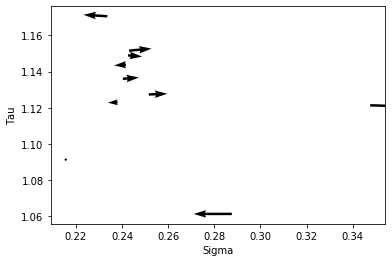

Data input success
Gradient:  [-0.19463787  0.04283083  0.9799396 ]
Likelihood:  789.2275951441338
Hp:  [0.19169287 1.26382026 0.2394395 ]  #  1
Gradient:  [ 0.9773891  -0.02048954 -0.21045362]
Likelihood:  744.7438068306632
Hp:  [0.21669287 1.20382026 0.1794395 ]  #  2
Gradient:  [ 0.82425197 -0.03101538 -0.5653731 ]
Likelihood:  779.4820194135772
Hp:  [0.24669287 1.13182026 0.1074395 ]  #  3
Gradient:  [-0.22433911  0.03537933  0.97386871]
Likelihood:  786.5765377525871
Hp:  [0.23169287 1.16782026 0.1434395 ]  #  4
Gradient:  [ 0.7441042  -0.02108821 -0.66773065]
Likelihood:  789.3188475735254
Hp:  [0.23919287 1.14982026 0.1254395 ]  #  5
Gradient:  [-0.05000795  0.05156647  0.99741672]
Likelihood:  789.8600492009356
Hp:  [0.23544287 1.15882026 0.1344395 ]  #  6
Gradient:  [ 0.97966514  0.0177813  -0.19985004]
Likelihood:  790.0210887021608
Hp:  [0.23731787 1.16962026 0.1299395 ]  #  7
Gradient:  [0.48959735 0.05934519 0.86992677]
Likelihood:  790.0799291621197
Hp:  [0.23956787 1.182

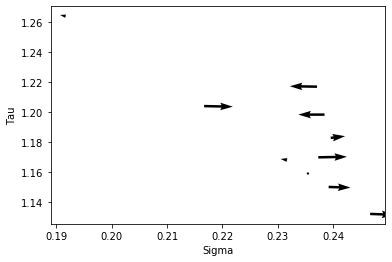

Data input success
Gradient:  [0.14750062 0.02179355 0.98882183]
Likelihood:  789.9140335233396
Hp:  [0.35709287 1.33679466 0.2497145 ]  #  1
Gradient:  [-0.86365458 -0.03828295 -0.50262828]
Likelihood:  632.901567381206
Hp:  [0.29709287 1.27679466 0.1897145 ]  #  2
Gradient:  [-0.87269894 -0.02837303 -0.48743361]
Likelihood:  737.5741433464409
Hp:  [0.22509287 1.20479466 0.1177145 ]  #  3
Gradient:  [0.65741336 0.02046422 0.75325221]
Likelihood:  784.0214922754499
Hp:  [0.26109287 1.24079466 0.1537145 ]  #  4
Gradient:  [-0.91339473 -0.02150324 -0.40650668]
Likelihood:  780.9346456495184
Hp:  [0.24309287 1.22279466 0.1357145 ]  #  5
Gradient:  [-0.94665704 -0.00382984  0.32222007]
Likelihood:  789.8878121917204
Hp:  [0.22149287 1.20119466 0.1447145 ]  #  6
Gradient:  [0.90411436 0.00889527 0.42719796]
Likelihood:  787.669096826833
Hp:  [0.23229287 1.21199466 0.1555145 ]  #  7
Gradient:  [ 0.61435149 -0.12653374 -0.77882056]
Likelihood:  790.8028791662358
Hp:  [0.24525287 1.20659466 0.

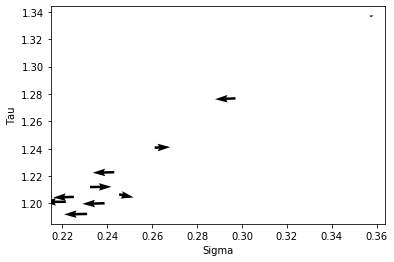

Data input success
Gradient:  [ 0.49280514 -0.13161132  0.8601288 ]
Likelihood:  800.652232532033
Hp:  [0.35099687 1.14233866 0.2668745 ]  #  1
Gradient:  [-0.86055581 -0.04507709 -0.50735761]
Likelihood:  640.4331396348439
Hp:  [0.29099687 1.08233866 0.2068745 ]  #  2
Gradient:  [-0.8610156  -0.03302591 -0.5075051 ]
Likelihood:  746.2853126243544
Hp:  [0.21899687 1.01033866 0.1348745 ]  #  3
Gradient:  [0.75458304 0.03303109 0.65537271]
Likelihood:  794.9581731407685
Hp:  [0.25499687 1.04633866 0.1708745 ]  #  4
Gradient:  [-0.87868162 -0.0226048  -0.47687277]
Likelihood:  790.640951505293
Hp:  [0.23699687 1.02833866 0.1528745 ]  #  5
Gradient:  [-0.98823392  0.01150781 -0.15251655]
Likelihood:  800.1621374751395
Hp:  [0.21539687 1.03733866 0.1312745 ]  #  6
Gradient:  [0.77532478 0.02799611 0.63094192]
Likelihood:  791.9346137727828
Hp:  [0.22619687 1.04813866 0.1420745 ]  #  7
Gradient:  [0.69606889 0.03807079 0.71696494]
Likelihood:  799.4593978682674
Hp:  [0.23915687 1.06109866 0.

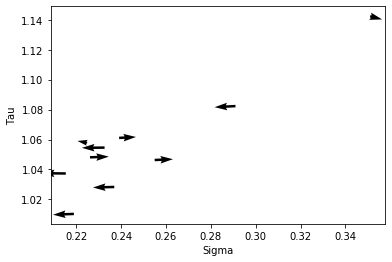

Data input success
Gradient:  [0.71127227 0.03462286 0.70206339]
Likelihood:  801.9448879907696
Hp:  [0.34490087 1.17785866 0.2717945 ]  #  1
Gradient:  [-0.85814648 -0.04522054 -0.51140954]
Likelihood:  647.9339773134315
Hp:  [0.28490087 1.11785866 0.2117945 ]  #  2
Gradient:  [-0.85848262 -0.03404763 -0.5117112 ]
Likelihood:  753.2018278921416
Hp:  [0.21290087 1.04585866 0.1397945 ]  #  3
Gradient:  [0.80005799 0.02622792 0.59934907]
Likelihood:  793.9746751222166
Hp:  [0.24890087 1.08185866 0.1757945 ]  #  4
Gradient:  [-0.87580334 -0.02571897 -0.48198241]
Likelihood:  795.4152016721957
Hp:  [0.23090087 1.06385866 0.1577945 ]  #  5
Gradient:  [-0.78325107  0.03885118  0.62049041]
Likelihood:  802.7184604354834
Hp:  [0.20930087 1.07285866 0.1667945 ]  #  6
Gradient:  [0.96998872 0.01025089 0.24293374]
Likelihood:  796.4689614687559
Hp:  [0.22010087 1.08365866 0.1775945 ]  #  7
Gradient:  [ 0.91972669 -0.02698512 -0.39163073]
Likelihood:  801.564966703173
Hp:  [0.23306087 1.07825866 0

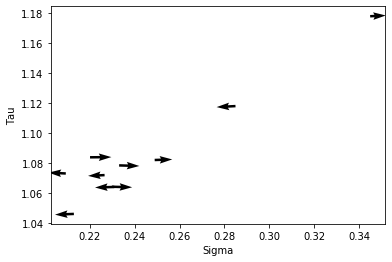

Data input success
Gradient:  [ 0.21149263 -0.02595692 -0.97703485]
Likelihood:  799.1435470963634
Hp:  [0.34982087 1.01400266 0.1079385 ]  #  1
Gradient:  [-9.82310686e-01  5.75968472e-04 -1.87257536e-01]
Likelihood:  699.9845272881455
Hp:  [0.28982087 1.03900266 0.0479385 ]  #  2
Gradient:  [-0.14768656  0.01807881  0.98886897]
Likelihood:  735.7380692629856
Hp:  [0.21782087 1.06900266 0.0779385 ]  #  3
Gradient:  [0.47126679 0.02351741 0.88167712]
Likelihood:  771.8457153232345
Hp:  [0.25382087 1.10500266 0.1139385 ]  #  4
Gradient:  [-0.9891393   0.02126323  0.14543492]
Likelihood:  798.5721674402819
Hp:  [0.23582087 1.14820266 0.1571385 ]  #  5
Gradient:  [-0.29227999 -0.03400798 -0.95572792]
Likelihood:  798.6167694416235
Hp:  [0.21422087 1.12660266 0.1355385 ]  #  6
Gradient:  [0.99654659 0.00939984 0.08250175]
Likelihood:  794.4247388946455
Hp:  [0.22502087 1.13740266 0.1463385 ]  #  7
Gradient:  [ 0.79536377 -0.01245702 -0.60600436]
Likelihood:  799.6528717227179
Hp:  [0.23798

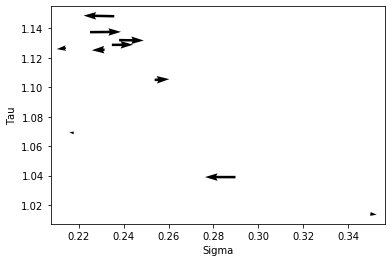

Data input success
Gradient:  [-0.66898929  0.08933923  0.73788335]
Likelihood:  812.8072324866389
Hp:  [0.18474087 1.24876266 0.2466825 ]  #  1
Gradient:  [ 0.97851293 -0.01751983 -0.20543975]
Likelihood:  770.1092017073304
Hp:  [0.20974087 1.18876266 0.1866825 ]  #  2
Gradient:  [ 0.85301536 -0.024799   -0.52129627]
Likelihood:  802.5863049515773
Hp:  [0.23974087 1.11676266 0.1146825 ]  #  3
Gradient:  [-0.46178503  0.05188834  0.88547286]
Likelihood:  811.186768774132
Hp:  [0.22474087 1.15276266 0.1506825 ]  #  4
Gradient:  [ 0.58867126 -0.01344184 -0.80826077]
Likelihood:  811.811301535296
Hp:  [0.23224087 1.13476266 0.1326825 ]  #  5
Gradient:  [-0.94493458  0.23033838 -0.23247124]
Likelihood:  813.0395158780135
Hp:  [0.22849087 1.14376266 0.1110825 ]  #  6
Gradient:  [0.42889112 0.03887552 0.90251931]
Likelihood:  810.3211569360518
Hp:  [0.23036587 1.15456266 0.1218825 ]  #  7
Gradient:  [0.42964723 0.05463359 0.90134257]
Likelihood:  812.5611278041561
Hp:  [0.23261587 1.16752266

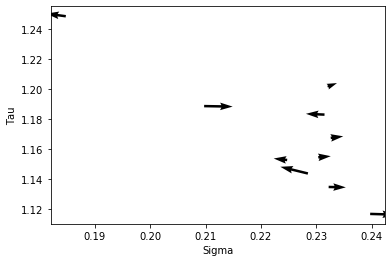

Data input success
Gradient:  [0.99578435 0.00855491 0.09132551]
Likelihood:  771.4785521284371
Hp:  [0.35205337 1.32173706 0.2516025 ]  #  1
Gradient:  [-0.83733872 -0.0402054  -0.54520399]
Likelihood:  627.4394571524475
Hp:  [0.29205337 1.26173706 0.1916025 ]  #  2
Gradient:  [-0.80691324 -0.03145827 -0.58983167]
Likelihood:  728.0058912347466
Hp:  [0.22005337 1.18973706 0.1196025 ]  #  3
Gradient:  [0.91298552 0.01522864 0.40770766]
Likelihood:  762.556996493521
Hp:  [0.25605337 1.22573706 0.1556025 ]  #  4
Gradient:  [-0.69820633 -0.02859363 -0.71532533]
Likelihood:  767.0011679510753
Hp:  [0.23805337 1.20773706 0.1376025 ]  #  5
Gradient:  [ 0.71586621 -0.01569224 -0.69806112]
Likelihood:  772.7468009250713
Hp:  [0.24705337 1.18613706 0.1160025 ]  #  6
Gradient:  [-0.2490748   0.05197195  0.96708875]
Likelihood:  773.0690033111409
Hp:  [0.24255337 1.19693706 0.1268025 ]  #  7
Gradient:  [ 0.97994742  0.05987183 -0.19004847]
Likelihood:  773.4357247182592
Hp:  [0.24480337 1.2098970

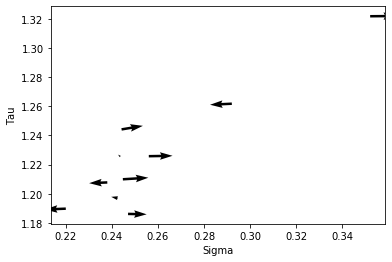

Data input success
Gradient:  [-0.89026249 -0.00896424 -0.45535957]
Likelihood:  807.5376634672788
Hp:  [0.19424087 1.19411146 0.0773425 ]  #  1
Gradient:  [0.66337878 0.01589863 0.74811485]
Likelihood:  738.5138870062044
Hp:  [0.21924087 1.21911146 0.1023425 ]  #  2
Gradient:  [0.66819196 0.02244526 0.74365027]
Likelihood:  800.3704958438632
Hp:  [0.24924087 1.24911146 0.1323425 ]  #  3
Gradient:  [-0.85304795 -0.01435589 -0.52163503]
Likelihood:  805.0963644608327
Hp:  [0.23424087 1.23411146 0.1173425 ]  #  4
Gradient:  [0.20994522 0.04737827 0.97656454]
Likelihood:  809.0661250598023
Hp:  [0.24174087 1.24161146 0.1248425 ]  #  5
Gradient:  [-0.9290688  -0.00308768 -0.36989407]
Likelihood:  808.3664276543968
Hp:  [0.23799087 1.23786146 0.1210925 ]  #  6
Gradient:  [-0.9880151   0.0266767   0.15203461]
Likelihood:  809.069784729487
Hp:  [0.23349087 1.23973646 0.1229675 ]  #  7
Gradient:  [0.61684577 0.08779393 0.78217231]
Likelihood:  809.2876570615559
Hp:  [0.23574087 1.24198646 0.12

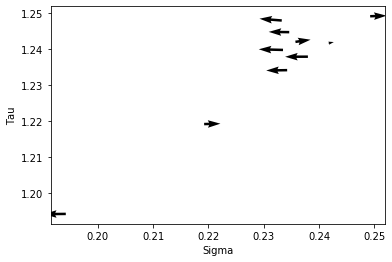

Data input success
Gradient:  [0.91681163 0.01324399 0.39910027]
Likelihood:  789.4877182092462
Hp:  [0.35326587 1.36792646 0.2427425 ]  #  1
Gradient:  [-0.82579513 -0.03914872 -0.5626098 ]
Likelihood:  632.9144723233247
Hp:  [0.29326587 1.30792646 0.1827425 ]  #  2
Gradient:  [-0.79229987 -0.03038311 -0.60937491]
Likelihood:  738.245049992876
Hp:  [0.22126587 1.23592646 0.1107425 ]  #  3
Gradient:  [0.78672476 0.01751967 0.61705528]
Likelihood:  782.0401948396155
Hp:  [0.25726587 1.27192646 0.1467425 ]  #  4
Gradient:  [-0.73504847 -0.02609372 -0.67751226]
Likelihood:  781.6662362982738
Hp:  [0.23926587 1.25392646 0.1287425 ]  #  5
Gradient:  [-0.25842084 -0.03098515 -0.96553539]
Likelihood:  789.9350054914565
Hp:  [0.21766587 1.23232646 0.1071425 ]  #  6
Gradient:  [0.77260118 0.01733882 0.63465485]
Likelihood:  777.7407268335215
Hp:  [0.22846587 1.24312646 0.1179425 ]  #  7
Gradient:  [0.83372335 0.0169617  0.5519218 ]
Likelihood:  787.6594776337677
Hp:  [0.24142587 1.25608646 0.13

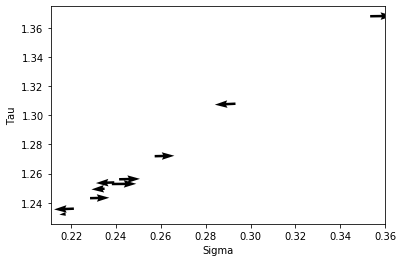

Data input success
Gradient:  [-0.39442804  0.01900315  0.91873032]
Likelihood:  800.465121126654
Hp:  [0.18818587 1.37284646 0.2476625 ]  #  1
Gradient:  [ 0.96275839 -0.02854144 -0.26885249]
Likelihood:  768.3418297152191
Hp:  [0.21318587 1.31284646 0.1876625 ]  #  2
Gradient:  [ 0.8137322  -0.04583276 -0.57943011]
Likelihood:  797.0960236553038
Hp:  [0.24318587 1.24084646 0.1156625 ]  #  3
Gradient:  [-0.34817634  0.02310106  0.93714437]
Likelihood:  797.4022980534296
Hp:  [0.22818587 1.27684646 0.1516625 ]  #  4
Gradient:  [ 0.9821899  -0.1865605   0.02231972]
Likelihood:  802.5883526385577
Hp:  [0.23568587 1.25884646 0.1948625 ]  #  5
Gradient:  [-0.61316264 -0.05026821 -0.78835568]
Likelihood:  795.5919334002687
Hp:  [0.23193587 1.23724646 0.1732625 ]  #  6
Gradient:  [-0.57284014 -0.05295289 -0.81795487]
Likelihood:  800.979446332905
Hp:  [0.22743587 1.21132646 0.1473425 ]  #  7
Gradient:  [0.63821612 0.00342164 0.76984964]
Likelihood:  802.5068194940615
Hp:  [0.22968587 1.22428

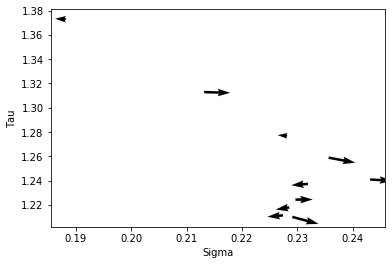

Data input success
Gradient:  [ 0.74166053 -0.44739446  0.4997778 ]
Likelihood:  801.3898695496265
Hp:  [0.34912337 1.16003046 0.2770625 ]  #  1
Gradient:  [-0.86680982 -0.04551906 -0.49655689]
Likelihood:  641.6650405958152
Hp:  [0.28912337 1.10003046 0.2170625 ]  #  2
Gradient:  [-0.86834058 -0.03418363 -0.49478896]
Likelihood:  747.2613616943243
Hp:  [0.21712337 1.02803046 0.1450625 ]  #  3
Gradient:  [0.7911951  0.02953983 0.61084999]
Likelihood:  796.0857432402653
Hp:  [0.25312337 1.06403046 0.1810625 ]  #  4
Gradient:  [-0.88494433 -0.02548497 -0.46499899]
Likelihood:  791.509428421391
Hp:  [0.23512337 1.04603046 0.1630625 ]  #  5
Gradient:  [-0.97976406 -0.00390821 -0.20011772]
Likelihood:  801.0622576606839
Hp:  [0.21352337 1.02443046 0.1414625 ]  #  6
Gradient:  [0.80295836 0.0277578  0.59538843]
Likelihood:  792.7136728479533
Hp:  [0.22432337 1.03523046 0.1522625 ]  #  7
Gradient:  [0.72512652 0.03653991 0.68764552]
Likelihood:  800.247214002792
Hp:  [0.23728337 1.04819046 0.

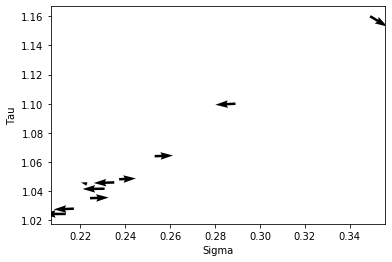

Data input success
Gradient:  [ 0.77836594 -0.02235536 -0.62741271]
Likelihood:  794.6607925695818
Hp:  [0.34302737 0.99495046 0.1119825 ]  #  1
Gradient:  [-9.87062395e-01 -2.93180798e-05 -1.60336605e-01]
Likelihood:  705.2167520958764
Hp:  [0.28302737 0.93495046 0.0519825 ]  #  2
Gradient:  [-0.13367875  0.02226159  0.99077465]
Likelihood:  737.3996926522676
Hp:  [0.21102737 0.96495046 0.0819825 ]  #  3
Gradient:  [0.52888483 0.0249736  0.84832609]
Likelihood:  754.7476452571431
Hp:  [0.24702737 1.00095046 0.1179825 ]  #  4
Gradient:  [-0.70071038  0.04921605  0.71174626]
Likelihood:  796.1333792462768
Hp:  [0.22902737 1.04415046 0.1611825 ]  #  5
Gradient:  [ 0.31148165 -0.03508411 -0.94960428]
Likelihood:  795.9477088921261
Hp:  [0.23802737 1.02255046 0.1395825 ]  #  6
Gradient:  [-0.64528435  0.00928083 -0.7638861 ]
Likelihood:  798.2498980291797
Hp:  [0.23352737 1.03335046 0.1136625 ]  #  7
Gradient:  [0.36345234 0.04349346 0.93059697]
Likelihood:  796.1282475825599
Hp:  [0.23577

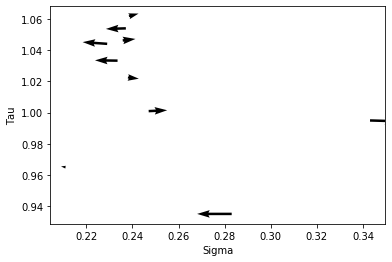

Data input success
Gradient:  [-0.97887846  0.11708625 -0.16759409]
Likelihood:  798.8658729696988
Hp:  [0.18712737 1.17408646 0.0843985 ]  #  1
Gradient:  [0.72910077 0.01570529 0.68422614]
Likelihood:  710.0359832804689
Hp:  [0.21212737 1.31808646 0.1093985 ]  #  2
Gradient:  [0.80587904 0.01527247 0.5918832 ]
Likelihood:  786.0262923133033
Hp:  [0.24212737 1.49088646 0.1393985 ]  #  3
Gradient:  [-0.59363248 -0.0307248  -0.80414953]
Likelihood:  796.2148709203453
Hp:  [0.22712737 1.40448646 0.1243985 ]  #  4
Gradient:  [ 0.97943484 -0.0010943   0.20175778]
Likelihood:  798.5255968719681
Hp:  [0.23462737 1.30080646 0.1318985 ]  #  5
Gradient:  [-0.22220932 -0.02819558 -0.97459121]
Likelihood:  799.3046686277137
Hp:  [0.23087737 1.17639046 0.1281485 ]  #  6
Gradient:  [0.85960373 0.04292506 0.50915506]
Likelihood:  799.0397421518294
Hp:  [0.23275237 1.23859846 0.1300235 ]  #  7
Gradient:  [ 0.94635386  0.0253384  -0.32213714]
Likelihood:  799.3689148363164
Hp:  [0.23500237 1.31324806 

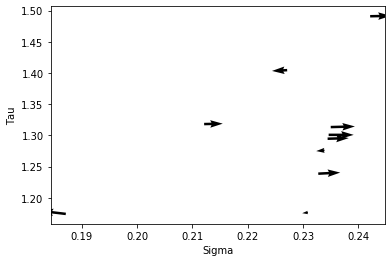

Data input success
Gradient:  [ 0.85443419 -0.01407383 -0.51936898]
Likelihood:  787.6346378668417
Hp:  [0.35443987 1.24458566 0.076611  ]  #  1
Gradient:  [-0.98429583  0.00671069  0.17639924]
Likelihood:  689.2381820373289
Hp:  [0.29443987 1.26958566 0.101611  ]  #  2
Gradient:  [-9.96113888e-01 -1.40918318e-05 -8.80745222e-02]
Likelihood:  759.2386220493255
Hp:  [0.22243987 1.25708566 0.089111  ]  #  3
Gradient:  [0.60450531 0.01861285 0.79638363]
Likelihood:  772.8327562229488
Hp:  [0.25843987 1.26333566 0.095361  ]  #  4
Gradient:  [-0.65053052  0.02231901  0.75915209]
Likelihood:  783.1888984749646
Hp:  [0.24043987 1.27083566 0.102861  ]  #  5
Gradient:  [0.26341189 0.02852072 0.96426176]
Likelihood:  786.9606699618749
Hp:  [0.24943987 1.27983566 0.111861  ]  #  6
Gradient:  [-0.97989432  0.01173455  0.19917185]
Likelihood:  787.3889487877955
Hp:  [0.24493987 1.29063566 0.122661  ]  #  7
Gradient:  [-0.73075268 -0.01678098 -0.68243602]
Likelihood:  787.9060415742381
Hp:  [0.23953

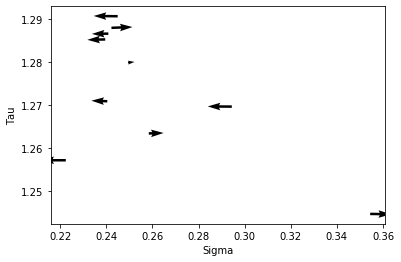

Data input success
Gradient:  [-0.24498085  0.01948981  0.969332  ]
Likelihood:  795.5483075299172
Hp:  [0.19088987 1.40658566 0.238611  ]  #  1
Gradient:  [ 0.9721832  -0.02605304 -0.23276825]
Likelihood:  770.210501187055
Hp:  [0.21588987 1.34658566 0.178611  ]  #  2
Gradient:  [ 0.89871275 -0.04191658 -0.43652994]
Likelihood:  795.4095457243503
Hp:  [0.24588987 1.27458566 0.106611  ]  #  3
Gradient:  [-0.23575227  0.02138873  0.97157778]
Likelihood:  791.8056105175099
Hp:  [0.23088987 1.31058566 0.142611  ]  #  4
Gradient:  [ 0.29317614 -0.01914554  0.95586673]
Likelihood:  798.9236369900856
Hp:  [0.23838987 1.29258566 0.185811  ]  #  5
Gradient:  [-0.68107815 -0.04631431 -0.73074451]
Likelihood:  793.7360839806954
Hp:  [0.23463987 1.27098566 0.164211  ]  #  6
Gradient:  [-0.72362405 -0.05070386 -0.68832939]
Likelihood:  798.2689490805415
Hp:  [0.23013987 1.24506566 0.138291  ]  #  7
Gradient:  [0.40941308 0.01384495 0.91224407]
Likelihood:  798.5099791052969
Hp:  [0.23238987 1.2580

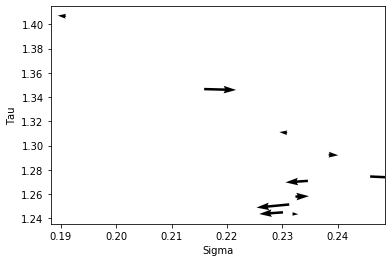

Data input success
Gradient:  [-0.96226852 -0.05416173  0.26665672]
Likelihood:  802.9461534719494
Hp:  [0.18182737 1.19376966 0.268011  ]  #  1
Gradient:  [ 0.98528444 -0.02213145 -0.16948382]
Likelihood:  759.6402789170618
Hp:  [0.20682737 1.13376966 0.208011  ]  #  2
Gradient:  [ 0.89577125 -0.03462906 -0.44316441]
Likelihood:  793.5525502441049
Hp:  [0.23682737 1.06176966 0.136011  ]  #  3
Gradient:  [-0.36954258  0.04368737  0.92818624]
Likelihood:  801.3316999455234
Hp:  [0.22182737 1.09776966 0.172011  ]  #  4
Gradient:  [ 0.86869652 -0.03372418 -0.49419533]
Likelihood:  802.4020833897922
Hp:  [0.22932737 1.07976966 0.154011  ]  #  5
Gradient:  [0.18077681 0.04454751 0.98251476]
Likelihood:  803.199045565747
Hp:  [0.23832737 1.08876966 0.163011  ]  #  6
Gradient:  [-0.89606947 -0.02223215 -0.44335678]
Likelihood:  801.6745476910567
Hp:  [0.23382737 1.08426966 0.158511  ]  #  7
Gradient:  [-0.953293   -0.01504091 -0.30167238]
Likelihood:  802.8994473795427
Hp:  [0.22842737 1.0788

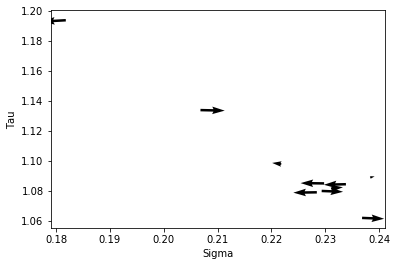

803.2579193470741
Data input success
Gradient:  [ 0.73042576 -0.02420224 -0.68256316]
Likelihood:  772.7166637621374
Hp:  [0.34977737 1.03480966 0.109051  ]  #  1
Gradient:  [-0.96972492 -0.00273462 -0.24418458]
Likelihood:  690.0306915751886
Hp:  [0.28977737 0.97480966 0.049051  ]  #  2
Gradient:  [-0.1400929   0.02025738  0.98993112]
Likelihood:  725.2632901737479
Hp:  [0.21777737 1.00480966 0.079051  ]  #  3
Gradient:  [0.58555499 0.02304294 0.81030512]
Likelihood:  742.6132425025651
Hp:  [0.25377737 1.04080966 0.115051  ]  #  4
Gradient:  [-0.96973376  0.04322285  0.2403086 ]
Likelihood:  777.1523908952901
Hp:  [0.23577737 1.08400966 0.158251  ]  #  5
Gradient:  [ 0.30691655 -0.03450248 -0.95111083]
Likelihood:  774.0710083914263
Hp:  [0.24477737 1.06240966 0.136651  ]  #  6
Gradient:  [-0.29588527 -0.01264198 -0.95513982]
Likelihood:  777.4173357117944
Hp:  [0.24027737 1.03648966 0.110731  ]  #  7
Gradient:  [0.56257453 0.05000418 0.82523299]
Likelihood:  776.9988330801542
Hp:  [0

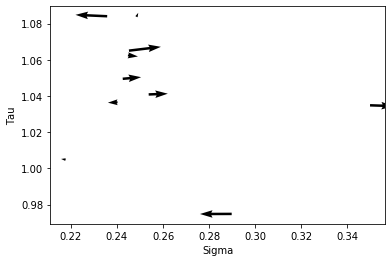

Data input success
Gradient:  [-0.68026933  0.02942454  0.73237138]
Likelihood:  796.759894440963
Hp:  [0.19846737 1.20366406 0.240451  ]  #  1
Gradient:  [ 0.84656519 -0.04641937 -0.53025712]
Likelihood:  777.8693745884015
Hp:  [0.22346737 1.14366406 0.180451  ]  #  2
Gradient:  [ 0.15118268 -0.06087184 -0.98662983]
Likelihood:  800.2581117538696
Hp:  [0.25346737 1.07166406 0.108451  ]  #  3
Gradient:  [-0.53732433  0.03101121  0.84280535]
Likelihood:  792.0894566503729
Hp:  [0.23846737 1.10766406 0.144451  ]  #  4
Gradient:  [-0.99659635  0.00241315  0.08240079]
Likelihood:  801.8272573894926
Hp:  [0.22046737 1.15086406 0.187651  ]  #  5
Gradient:  [ 0.31235954 -0.06076444 -0.94801857]
Likelihood:  798.7873994183002
Hp:  [0.22946737 1.12926406 0.166051  ]  #  6
Gradient:  [-0.35058464 -0.05373694 -0.9349881 ]
Likelihood:  802.0888270409623
Hp:  [0.22496737 1.10334406 0.140131  ]  #  7
Gradient:  [0.66273741 0.0285497  0.74830745]
Likelihood:  801.6575394565899
Hp:  [0.22721737 1.1163

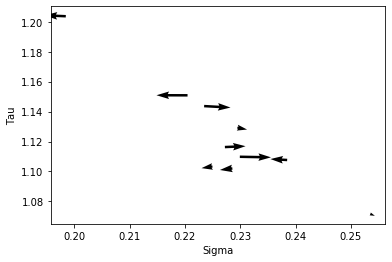

Data input success
Gradient:  [ 0.35080984 -0.14744903 -0.92476551]
Likelihood:  802.5075395856338
Hp:  [0.34856737 1.05204806 0.110867  ]  #  1
Gradient:  [-0.99039287 -0.00108796 -0.13827792]
Likelihood:  696.6011716248489
Hp:  [0.28856737 0.99204806 0.050867  ]  #  2
Gradient:  [-0.16260445  0.01994961  0.98648964]
Likelihood:  733.3378314170466
Hp:  [0.21656737 1.02204806 0.080867  ]  #  3
Gradient:  [0.47004111 0.02308039 0.88234271]
Likelihood:  756.3075298825037
Hp:  [0.25256737 1.05804806 0.116867  ]  #  4
Gradient:  [-0.65085476  0.03173618  0.75853866]
Likelihood:  793.2434193374352
Hp:  [0.23456737 1.10124806 0.160067  ]  #  5
Gradient:  [-0.93686121 -0.02177554 -0.34902277]
Likelihood:  802.0174667399832
Hp:  [0.21296737 1.07964806 0.138467  ]  #  6
Gradient:  [0.80014359 0.02353152 0.59934672]
Likelihood:  793.858639326622
Hp:  [0.22376737 1.09044806 0.149267  ]  #  7
Gradient:  [0.74562474 0.02654351 0.66583721]
Likelihood:  801.3579961093704
Hp:  [0.23672737 1.10340806 0

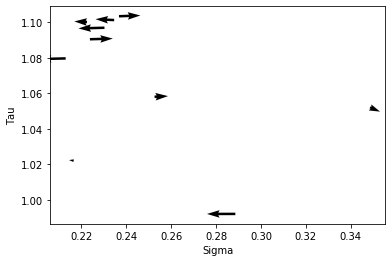

Data input success
Gradient:  [0.95215197 0.00890214 0.30549529]
Likelihood:  791.3495291021763
Hp:  [0.34247137 1.22016806 0.278987  ]  #  1
Gradient:  [-0.86481529 -0.04572644 -0.5000036 ]
Likelihood:  645.9740257657087
Hp:  [0.28247137 1.16016806 0.218987  ]  #  2
Gradient:  [-0.85524854 -0.03663107 -0.51692176]
Likelihood:  747.9768818270325
Hp:  [0.21047137 1.08816806 0.146987  ]  #  3
Gradient:  [0.90661666 0.01662565 0.42162759]
Likelihood:  782.0059031202992
Hp:  [0.24647137 1.12416806 0.182987  ]  #  4
Gradient:  [-0.81889139 -0.03549597 -0.57284983]
Likelihood:  787.2750057656184
Hp:  [0.22847137 1.10616806 0.164987  ]  #  5
Gradient:  [ 0.96955233 -0.03302752 -0.2426468 ]
Likelihood:  792.7754594577847
Hp:  [0.23747137 1.08456806 0.143387  ]  #  6
Gradient:  [-0.43914856  0.04080573  0.89748729]
Likelihood:  792.4952249759605
Hp:  [0.23297137 1.09536806 0.154187  ]  #  7
Gradient:  [0.39560872 0.0196635  0.91820863]
Likelihood:  793.0026255543156
Hp:  [0.23522137 1.10832806 

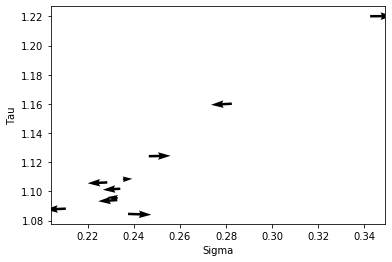

Data input success
Gradient:  [-0.64982413 -0.0254832  -0.75965729]
Likelihood:  799.2197060237961
Hp:  [0.18274637 1.04407206 0.102891  ]  #  1
Gradient:  [0.81327048 0.01782229 0.58161284]
Likelihood:  707.2826363134892
Hp:  [0.20774637 1.06907206 0.127891  ]  #  2
Gradient:  [0.83461733 0.02163047 0.55040534]
Likelihood:  782.3671328687903
Hp:  [0.23774637 1.09907206 0.157891  ]  #  3
Gradient:  [-0.80079489 -0.02653393 -0.59835064]
Likelihood:  798.3191217797794
Hp:  [0.22274637 1.08407206 0.142891  ]  #  4
Gradient:  [0.85723712 0.02383441 0.51436995]
Likelihood:  797.2895522749475
Hp:  [0.23024637 1.09157206 0.150391  ]  #  5
Gradient:  [0.97422306 0.02247571 0.22446441]
Likelihood:  799.232301186082
Hp:  [0.23924637 1.10057206 0.159391  ]  #  6
Gradient:  [-0.80841464 -0.02675173 -0.58800521]
Likelihood:  797.8373940923693
Hp:  [0.23474637 1.09607206 0.154891  ]  #  7
Gradient:  [-0.7652529  -0.02610737 -0.64320012]
Likelihood:  798.9944514122393
Hp:  [0.22934637 1.09067206 0.14

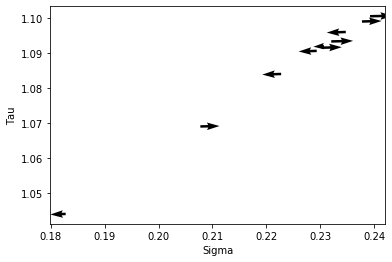

Data input success
Gradient:  [0.04310554 0.04080211 0.998237  ]
Likelihood:  802.1096557759241
Hp:  [0.35069637 1.21202206 0.270841  ]  #  1
Gradient:  [-0.85977168 -0.04409588 -0.50877128]
Likelihood:  639.5010834866214
Hp:  [0.29069637 1.15202206 0.210841  ]  #  2
Gradient:  [-0.86371075 -0.03306594 -0.50290197]
Likelihood:  746.3502188759509
Hp:  [0.21869637 1.08002206 0.138841  ]  #  3
Gradient:  [0.73153385 0.02750999 0.6812499 ]
Likelihood:  797.2057700753817
Hp:  [0.25469637 1.11602206 0.174841  ]  #  4
Gradient:  [-0.88971826 -0.02487171 -0.455832  ]
Likelihood:  791.5696399443863
Hp:  [0.23669637 1.09802206 0.156841  ]  #  5
Gradient:  [-0.99486447 -0.00744834 -0.10094159]
Likelihood:  801.6556303604326
Hp:  [0.21509637 1.07642206 0.135241  ]  #  6
Gradient:  [0.75329738 0.0259541  0.65716774]
Likelihood:  793.931975830969
Hp:  [0.22589637 1.08722206 0.146041  ]  #  7
Gradient:  [0.60462338 0.03313305 0.79582207]
Likelihood:  801.1612359537165
Hp:  [0.23885637 1.10018206 0.15

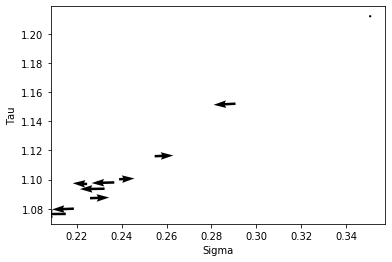

Data input success
Gradient:  [0.83487052 0.01947592 0.55010172]
Likelihood:  802.3208074931025
Hp:  [0.34460037 1.21694206 0.275761  ]  #  1
Gradient:  [-0.85206794 -0.04590531 -0.52141436]
Likelihood:  644.897812861912
Hp:  [0.28460037 1.15694206 0.215761  ]  #  2
Gradient:  [-0.84718094 -0.03566916 -0.5301058 ]
Likelihood:  751.1214764034899
Hp:  [0.21260037 1.08494206 0.143761  ]  #  3
Gradient:  [0.83773671 0.02175342 0.54564089]
Likelihood:  795.2597108916599
Hp:  [0.24860037 1.12094206 0.179761  ]  #  4
Gradient:  [-0.84466304 -0.03038089 -0.53443555]
Likelihood:  794.4987699827985
Hp:  [0.23060037 1.10294206 0.161761  ]  #  5
Gradient:  [-0.85589302 -0.04040909 -0.51557177]
Likelihood:  802.7151839212751
Hp:  [0.20900037 1.08134206 0.140161  ]  #  6
Gradient:  [0.83748104 0.02145096 0.5460452 ]
Likelihood:  791.1937710831862
Hp:  [0.21980037 1.09214206 0.150961  ]  #  7
Gradient:  [0.83746366 0.02171899 0.54606127]
Likelihood:  800.5903327892761
Hp:  [0.23276037 1.10510206 0.16

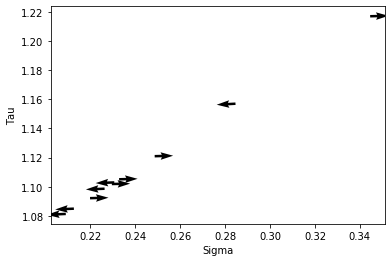

Data input success
Gradient:  [ 0.70866624 -0.02533106 -0.705089  ]
Likelihood:  792.749019026136
Hp:  [0.34952037 1.05186206 0.110681  ]  #  1
Gradient:  [-9.87285540e-01 -9.29514617e-04 -1.58954079e-01]
Likelihood:  693.2830591834983
Hp:  [0.28952037 0.99186206 0.050681  ]  #  2
Gradient:  [-0.16206218  0.0202062   0.98657365]
Likelihood:  730.0391589210407
Hp:  [0.21752037 1.02186206 0.080681  ]  #  3
Gradient:  [0.49846918 0.02341121 0.86659125]
Likelihood:  751.4160457297218
Hp:  [0.25352037 1.05786206 0.116681  ]  #  4
Gradient:  [-0.70396675  0.03547205  0.70934657]
Likelihood:  787.294842082106
Hp:  [0.23552037 1.10106206 0.159881  ]  #  5
Gradient:  [-0.52384343 -0.032063   -0.85121092]
Likelihood:  792.8079423620475
Hp:  [0.21392037 1.07946206 0.138281  ]  #  6
Gradient:  [0.89437674 0.02033541 0.44685201]
Likelihood:  783.9461137127178
Hp:  [0.22472037 1.09026206 0.149081  ]  #  7
Gradient:  [0.95299112 0.01840043 0.302439  ]
Likelihood:  791.7350033138558
Hp:  [0.23768037 1

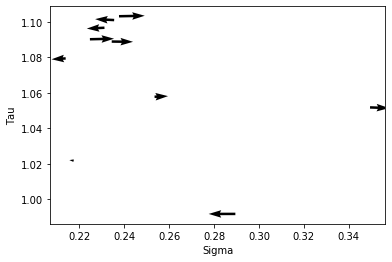

Data input success
Gradient:  [ 0.27094668 -0.0211222  -0.96236259]
Likelihood:  787.5713836430047
Hp:  [0.35444037 1.03896606 0.097785  ]  #  1
Gradient:  [-0.99852129  0.00458685 -0.05416826]
Likelihood:  686.895513098932
Hp:  [0.29444037 1.06396606 0.037785  ]  #  2
Gradient:  [-0.07475439  0.01376065  0.99710703]
Likelihood:  702.2237826765023
Hp:  [0.22244037 1.09396606 0.067785  ]  #  3
Gradient:  [0.38300801 0.0196099  0.92353685]
Likelihood:  744.1254507266947
Hp:  [0.25844037 1.12996606 0.103785  ]  #  4
Gradient:  [-0.69152336  0.02928645  0.72176017]
Likelihood:  782.9557078762242
Hp:  [0.24044037 1.17316606 0.146985  ]  #  5
Gradient:  [-0.32863344 -0.03132606 -0.94393789]
Likelihood:  787.1768166656515
Hp:  [0.21884037 1.15156606 0.125385  ]  #  6
Gradient:  [0.94748799 0.01476435 0.31945035]
Likelihood:  781.7146697724289
Hp:  [0.22964037 1.16236606 0.136185  ]  #  7
Gradient:  [ 0.94916977 -0.00173162 -0.31475984]
Likelihood:  787.6708242887669
Hp:  [0.24260037 1.1569660

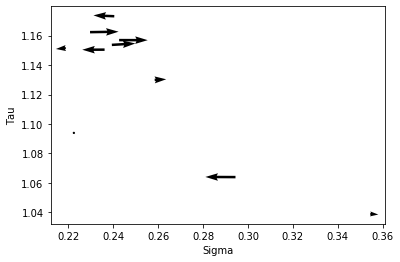

Data input success
Gradient:  [-0.95816993  0.02035724 -0.285475  ]
Likelihood:  808.6300037234502
Hp:  [0.18936037 1.27372606 0.077545  ]  #  1
Gradient:  [0.70809599 0.01369504 0.70598336]
Likelihood:  727.6966306961318
Hp:  [0.21436037 1.41772606 0.102545  ]  #  2
Gradient:  [0.76823529 0.01349978 0.64002523]
Likelihood:  798.5089991871527
Hp:  [0.24436037 1.59052606 0.132545  ]  #  3
Gradient:  [-0.67548018 -0.02589367 -0.73692336]
Likelihood:  805.1139498334649
Hp:  [0.22936037 1.50412606 0.117545  ]  #  4
Gradient:  [ 0.96092534 -0.00955985  0.27664255]
Likelihood:  808.9964718252534
Hp:  [0.23686037 1.40044606 0.125045  ]  #  5
Gradient:  [-0.68609477 -0.02518265 -0.7270762 ]
Likelihood:  809.0014291963138
Hp:  [0.23311037 1.27603006 0.121295  ]  #  6
Gradient:  [0.47510752 0.05742036 0.87805225]
Likelihood:  809.3113899166484
Hp:  [0.23498537 1.33823806 0.12317   ]  #  7
Gradient:  [-0.76258718 -0.01290415 -0.64675674]
Likelihood:  809.3326907800083
Hp:  [0.23404787 1.30713406 

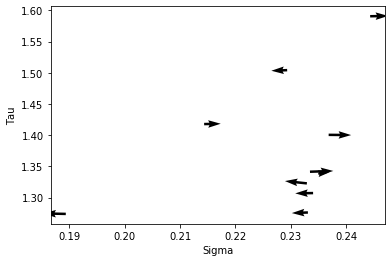

Data input success
Gradient:  [ 0.99422426 -0.00498317  0.10720679]
Likelihood:  777.0319122709524
Hp:  [0.35348537 1.29134846 0.24246687]  #  1
Gradient:  [-0.85524641 -0.0386348  -0.51677938]
Likelihood:  635.1125744249816
Hp:  [0.29348537 1.23134846 0.18246687]  #  2
Gradient:  [-0.83025231 -0.02988548 -0.55658599]
Likelihood:  734.7945389503403
Hp:  [0.22148537 1.15934846 0.11046687]  #  3
Gradient:  [0.85476374 0.01680679 0.5187451 ]
Likelihood:  767.3092721494957
Hp:  [0.25748537 1.19534846 0.14646687]  #  4
Gradient:  [-0.75171444 -0.02637756 -0.65896102]
Likelihood:  773.12405445636
Hp:  [0.23948537 1.17734846 0.12846687]  #  5
Gradient:  [ 0.95063563 -0.00265572 -0.310298  ]
Likelihood:  778.3891841052615
Hp:  [0.24848537 1.15574846 0.10686687]  #  6
Gradient:  [-0.13126032  0.03681466  0.99066413]
Likelihood:  777.4603806806457
Hp:  [0.24398537 1.16654846 0.11766687]  #  7
Gradient:  [0.29700642 0.0468465  0.95372564]
Likelihood:  778.5450985156101
Hp:  [0.24623537 1.17950846

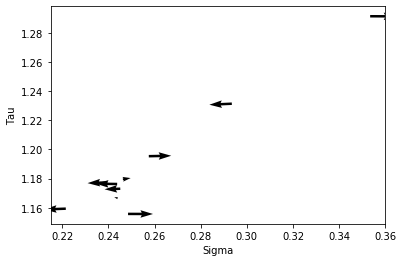

Data input success
Gradient:  [-0.78466349  0.0487031   0.61800584]
Likelihood:  793.8581054457813
Hp:  [0.19376037 1.29626846 0.23637087]  #  1
Gradient:  [ 0.97106844 -0.02313363 -0.23767819]
Likelihood:  753.167678368537
Hp:  [0.21876037 1.23626846 0.17637087]  #  2
Gradient:  [ 0.7417003  -0.03317429 -0.66991054]
Likelihood:  783.9829724153599
Hp:  [0.24876037 1.16426846 0.10437087]  #  3
Gradient:  [-0.48144549  0.03800096  0.87565185]
Likelihood:  791.7862249742851
Hp:  [0.23376037 1.20026846 0.14037087]  #  4
Gradient:  [ 0.27627423 -0.02383987 -0.96078312]
Likelihood:  793.2517302853693
Hp:  [0.24126037 1.18226846 0.12237087]  #  5
Gradient:  [-0.99685266  0.04957397 -0.06186436]
Likelihood:  794.2443438439495
Hp:  [0.23751037 1.19126846 0.10077087]  #  6
Gradient:  [0.27934811 0.03261595 0.95963578]
Likelihood:  791.388656025649
Hp:  [0.23938537 1.20206846 0.11157087]  #  7
Gradient:  [0.14358472 0.04470972 0.98862757]
Likelihood:  793.775903494831
Hp:  [0.24163537 1.21502846 

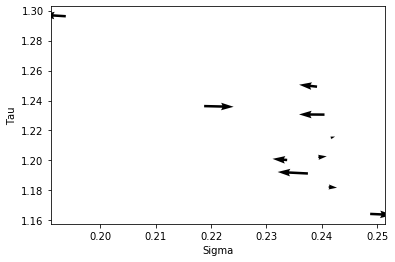

Data input success
Gradient:  [-0.91038274  0.02654892  0.41291455]
Likelihood:  808.2437648385747
Hp:  [0.18916037 1.36924286 0.24129087]  #  1
Gradient:  [ 0.93432208 -0.02721157 -0.35538963]
Likelihood:  764.0909893985536
Hp:  [0.21416037 1.30924286 0.18129087]  #  2
Gradient:  [ 0.61390611 -0.03779486 -0.78847374]
Likelihood:  798.7194943753497
Hp:  [0.24416037 1.23724286 0.10929087]  #  3
Gradient:  [-0.59919649  0.03093061  0.80000429]
Likelihood:  805.9090355568014
Hp:  [0.22916037 1.27324286 0.14529087]  #  4
Gradient:  [-0.02075685 -0.03163622 -0.99928389]
Likelihood:  808.0615563280544
Hp:  [0.21116037 1.25524286 0.12729087]  #  5
Gradient:  [0.93816622 0.01322677 0.34593236]
Likelihood:  801.1634754207074
Hp:  [0.22016037 1.26424286 0.13629087]  #  6
Gradient:  [ 0.99991825  0.00392417 -0.01216911]
Likelihood:  807.0960548411837
Hp:  [0.23096037 1.27504286 0.13179087]  #  7
Gradient:  [ 0.07066831 -0.00318465 -0.99749479]
Likelihood:  809.0810595139409
Hp:  [0.24392037 1.269

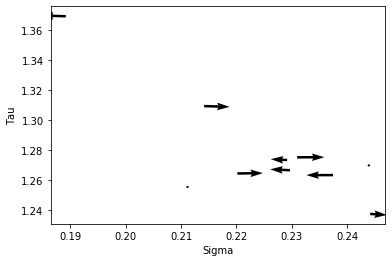

Data input success
Gradient:  [0.57206959 0.01893373 0.81998652]
Likelihood:  795.1564931663621
Hp:  [0.34966437 1.38640286 0.24315087]  #  1
Gradient:  [-0.8402256  -0.03814525 -0.54089359]
Likelihood:  642.9356349048953
Hp:  [0.28966437 1.32640286 0.18315087]  #  2
Gradient:  [-0.83734193 -0.02884352 -0.54591807]
Likelihood:  748.584028056918
Hp:  [0.21766437 1.25440286 0.11115087]  #  3
Gradient:  [0.68858438 0.01804506 0.72493167]
Likelihood:  785.4099083417875
Hp:  [0.25366437 1.29040286 0.14715087]  #  4
Gradient:  [-0.86942016 -0.02344607 -0.49351683]
Likelihood:  790.2545113364608
Hp:  [0.23566437 1.27240286 0.12915087]  #  5
Gradient:  [-0.03466235  0.01153741  0.99933248]
Likelihood:  796.517754625329
Hp:  [0.21406437 1.28140286 0.13815087]  #  6
Gradient:  [0.95200942 0.00492642 0.30602906]
Likelihood:  789.8157947408813
Hp:  [0.22486437 1.29220286 0.14895087]  #  7
Gradient:  [ 0.95790245 -0.02888237 -0.28563738]
Likelihood:  795.4704220813605
Hp:  [0.23782437 1.28680286 0.

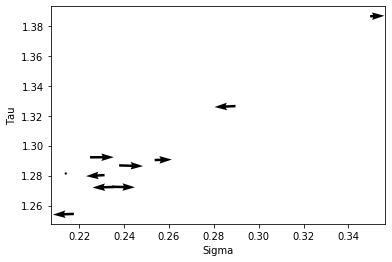

Data input success
Gradient:  [ 0.72263609 -0.034777   -0.69035327]
Likelihood:  775.644783039032
Hp:  [0.35458437 1.22254686 0.09031087]  #  1
Gradient:  [-9.94755483e-01 -6.55619264e-04 -1.02279512e-01]
Likelihood:  684.5845814253437
Hp:  [0.29458437 1.16254686 0.03031087]  #  2
Gradient:  [-0.02991722  0.00943155  0.99950788]
Likelihood:  677.9463615944818
Hp:  [0.22258437 1.19254686 0.06031087]  #  3
Gradient:  [0.41271902 0.01479114 0.91073829]
Likelihood:  725.9670462683561
Hp:  [0.25858437 1.22854686 0.09631087]  #  4
Gradient:  [-0.50794077  0.02262366  0.86109485]
Likelihood:  773.090925899768
Hp:  [0.24058437 1.27174686 0.13951087]  #  5
Gradient:  [ 0.00248922 -0.04542268 -0.99896476]
Likelihood:  776.2714128033537
Hp:  [0.24958437 1.25014686 0.11791087]  #  6
Gradient:  [-0.99984319 -0.0037657  -0.01730388]
Likelihood:  777.054006150637
Hp:  [0.24508437 1.22422686 0.09199087]  #  7
Gradient:  [0.19099516 0.02363214 0.98130646]
Likelihood:  772.6156198510457
Hp:  [0.24733437

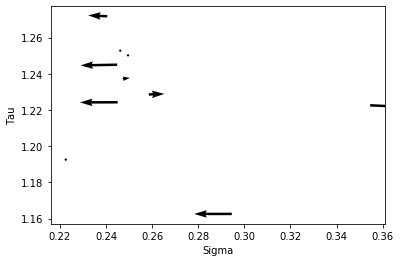

Data input success
Gradient:  [-0.29188739  0.02725928  0.95606416]
Likelihood:  787.2302580422212
Hp:  [0.19485937 1.36496286 0.23272687]  #  1
Gradient:  [ 0.96092401 -0.0238689  -0.27578129]
Likelihood:  749.5033056189577
Hp:  [0.21985937 1.30496286 0.17272687]  #  2
Gradient:  [ 0.76254043 -0.03512681 -0.64598622]
Likelihood:  781.3456822907224
Hp:  [0.24985937 1.23296286 0.10072687]  #  3
Gradient:  [-0.24911686  0.02586789  0.96812791]
Likelihood:  783.7362003319249
Hp:  [0.23485937 1.26896286 0.13672687]  #  4
Gradient:  [ 0.70672589 -0.04052273 -0.70632601]
Likelihood:  788.976408122518
Hp:  [0.24235937 1.25096286 0.11872687]  #  5
Gradient:  [-0.2978114   0.0271574   0.95423836]
Likelihood:  788.2828550494055
Hp:  [0.23860937 1.25996286 0.12772687]  #  6
Gradient:  [-0.1304479   0.01935317  0.99126626]
Likelihood:  789.068021175476
Hp:  [0.23410937 1.27076286 0.13852687]  #  7
Gradient:  [ 0.67184583 -0.03914229 -0.73965605]
Likelihood:  788.860058772167
Hp:  [0.23635937 1.265

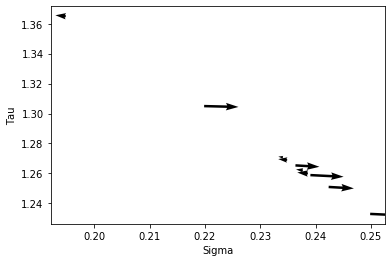

Data input success
Gradient:  [-0.20027151  0.03656507  0.97905787]
Likelihood:  790.4338198106357
Hp:  [0.18770937 1.38212286 0.24988687]  #  1
Gradient:  [ 0.9802028  -0.0199362  -0.19698992]
Likelihood:  746.050462806374
Hp:  [0.21270937 1.32212286 0.18988687]  #  2
Gradient:  [ 0.85585831 -0.03004428 -0.516337  ]
Likelihood:  780.0719484475728
Hp:  [0.24270937 1.25012286 0.11788687]  #  3
Gradient:  [-0.29666589  0.03269096  0.95442163]
Likelihood:  788.8070918491608
Hp:  [0.22770937 1.28612286 0.15388687]  #  4
Gradient:  [ 0.7642413  -0.02936608 -0.64426149]
Likelihood:  789.6280732928185
Hp:  [0.23520937 1.26812286 0.13588687]  #  5
Gradient:  [0.30584939 0.0363845  0.95138442]
Likelihood:  790.7111080547777
Hp:  [0.24420937 1.27712286 0.14488687]  #  6
Gradient:  [-0.84853599 -0.01949536 -0.5287784 ]
Likelihood:  789.1514317731359
Hp:  [0.23970937 1.27262286 0.14038687]  #  7
Gradient:  [-0.89338488 -0.01540782 -0.4490279 ]
Likelihood:  790.3927502933536
Hp:  [0.23430937 1.2672

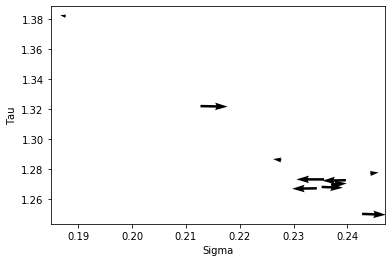

In [227]:
# See if there is a correlation between GP likelihood and correlation between putative and real driver
# Not so sure about this approach because the data ALREADY CONTAINS the information about the driver,
# so including it again may be redundant. Let us see...

ntrials = 100
correlation = np.zeros(ntrials)
likelihoods = np.zeros(ntrials)

bestPutativeDriver = np.zeros(X.shape[0])
bestPutativeDriverObjectively = np.zeros(X.shape[0])

gp.setCovar("sqrexp")

for t in range(ntrials):
    # driver is just some nice brownian motion
    # putativeDriver = np.cumsum(rand.normal(0,1,Xemb.shape[0])-0.5).reshape((Xemb.shape[0],1))
    # putativeDriver = np.cumsum(rand.rand(Xemb.shape[0])-0.5).reshape((Xemb.shape[0],1))
    # putativeDriver = np.real(fft.ifft(rand.rand(3),n=Xemb.shape[0]))
    putativeDriver = rand.multivariate_normal(np.zeros(putativeDriverCovarMatrix.shape[0]),putativeDriverCovarMatrix)
    putativeDriver = standardize(putativeDriver)
    
    newCorrelation = abs(np.dot(putativeDriver.flatten(), gts) / (la.norm(putativeDriver) * la.norm(gts)))
    
    # use GP, find likelihood
    gp.setData(np.append(Xemb, putativeDriver[embdim:].reshape(Xemb.shape[0],1), 1),Yemb)
    gp.hyperParamOptimize(10)
    newLikelihood = gp.hyperParamLikelihood()
    
    if newLikelihood > np.max(likelihoods):
        bestPutativeDriver = putativeDriver
    if newCorrelation > np.max(correlation):
        print(newLikelihood)
        bestPutativeDriverObjectively = putativeDriver
        
    correlation[t] = newCorrelation
    likelihoods[t] = newLikelihood

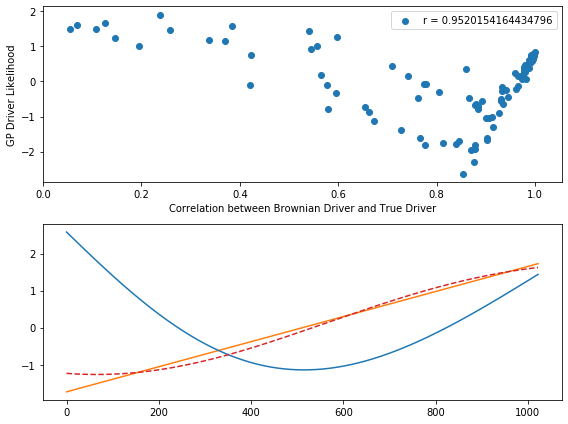

In [229]:
figBrown, axBrown = plt.subplots(2,figsize=(8,6))
axBrown[0].scatter(correlation, standardize(likelihoods))
axBrown[0].set_xlabel("Correlation between Brownian Driver and True Driver")
axBrown[0].set_ylabel("GP Driver Likelihood")
axBrown[0].legend(["r = {R}".format(R=np.dot(correlation,likelihoods)/(la.norm(correlation)*la.norm(likelihoods)))])

axBrown[1].plot(standardize(gts),c="tab:orange")
axBrown[1].plot(standardize(bestPutativeDriver),c="tab:blue")
axBrown[1].plot(standardize(bestPutativeDriverObjectively),"--",c="tab:red")

plt.tight_layout()
plt.show()

In [233]:
# try optimizing GP using forgetting covar function, then use hyperparams from that to generate putative drivers

embdim = 4

gp.setCovar("sqrexpf")
gp.setPrior(2,"half-normal")
gp.setPrior(3,"exponential")

gp.setData(X,Y)
gp.setTimeDelayEmbedding([embdim])

Prior dict  {0: 'none', 1: 'none', 2: 'half-normal', 3: 'exponential', 4: 'none', 5: 'none', 6: 'none', 7: 'none', 8: 'none', 9: 'none', 10: 'none', 11: 'none'}
Covariance function set to  sqrexpf
Prior dict  {0: 'none', 1: 'none', 2: 'half-normal', 3: 'exponential', 4: 'none', 5: 'none', 6: 'none', 7: 'none', 8: 'none', 9: 'none', 10: 'none', 11: 'none'}
Prior dict  {0: 'none', 1: 'none', 2: 'half-normal', 3: 'exponential', 4: 'none', 5: 'none', 6: 'none', 7: 'none', 8: 'none', 9: 'none', 10: 'none', 11: 'none'}
Data input success
tmp  (1023, 5)
r  [5.35229857 5.35229857 5.35229857 5.35229857]
Prior dict  {0: 'none', 1: 'none', 2: 'half-normal', 3: 'exponential', 4: 'none', 5: 'none', 6: 'none', 7: 'none', 8: 'none', 9: 'none', 10: 'none', 11: 'none'}
New X Dimensions  (1019, 5)


Gradient:  [-0.80786462 -0.4259754  -0.1528865  -0.29735036  0.12936706  0.15680132
  0.09727043  0.05765569]
Likelihood:  116.00677143996798
Hp:  [0.45 0.45 0.45 0.45 0.22 0.22 0.22 0.22]  #  1
Gradient:  [-0.80377832 -0.47746018 -0.13208157 -0.32262059  0.05320069  0.03735279
 -0.00253292 -0.01451355]
Likelihood:  194.32613550757532
Hp:  [0.39  0.39  0.39  0.39  0.364 0.364 0.16  0.16 ]  #  2
Gradient:  [-0.80050393 -0.45108481 -0.11549583 -0.37577089  0.02856531  0.01210588
 -0.0112175  -0.00919473]
Likelihood:  285.374624660525
Hp:  [0.318  0.318  0.318  0.318  0.5368 0.5368 0.088  0.088 ]  #  3
Gradient:  [-0.80103972 -0.36795419 -0.06195715 -0.46745451  0.01085239 -0.00533716
 -0.00842701  0.01937519]
Likelihood:  396.13077728982864
Hp:  [0.2316  0.2316  0.2316  0.2316  0.74416 0.4504  0.0016  0.124  ]  #  4
Gradient:  [-0.70622897  0.17028673  0.18596057 -0.6544394   0.01469054  0.00747573
  0.03035194  0.09043153]
Likelihood:  514.8958141443279
Hp:  [0.12792  0.2748   0.2748   

Hp:  [1.70685036e-01 4.01303961e-01 1.04892639e+00 6.86605460e-04
 1.00000000e+00 4.83864605e-01 3.03707345e-01 5.86246523e-01]  #  32
Gradient:  [-7.01866804e-03  2.63284865e-03 -3.27470536e-04 -9.99960893e-01
  2.92590041e-03 -1.56451337e-03 -3.40106119e-04 -3.28436440e-03]
Likelihood:  848.033635966988
Hp:  [1.67989423e-01 4.02427133e-01 9.59492436e-01 6.05357495e-04
 1.00000000e+00 4.83396617e-01 3.01011732e-01 5.70719795e-01]  #  33
Gradient:  [ 0.05150937  0.043849    0.00488632  0.99727128  0.02187291 -0.00776427
  0.00119455 -0.01760782]
Likelihood:  848.4348450022655
Hp:  [1.69337230e-01 4.03774939e-01 1.00420941e+00 6.45981477e-04
 1.00000000e+00 4.82835031e-01 3.02359539e-01 5.52087721e-01]  #  34
Gradient:  [ 1.58474135e-03  1.08679764e-02  4.16890538e-04 -9.99887586e-01
  7.09003948e-03 -3.18533429e-03 -8.99135064e-05 -6.60253367e-03]
Likelihood:  848.8672103569276
Hp:  [1.70954597e-01 4.05392307e-01 1.05786978e+00 6.25669486e-04
 1.00000000e+00 4.82161128e-01 3.01685635e-

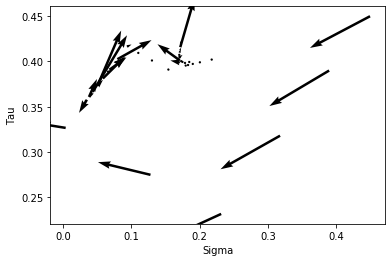

In [234]:
gp.hyperParamOptimize(steps=40)

In [1]:
nDrivers = 3

tau = 4.19835269e-01 # gp.hp[1]
phi = 1.05652827e+00 # gp.hp[2]
aphi = 5.95445243e-04 # gp.hp[3]

putativeDriverCovarMatrix = np.fromfunction(lambda i,j: tau*np.exp(-aphi*abs(i-j)**2/2),(X.shape[0],X.shape[0]))

figDriverCov, axDriverCov = plt.subplots(2,figsize=(8,12))
pltFigDriver = axDriverCov[0].imshow(putativeDriverCovarMatrix)
# plt.colorbar(pltFigDriver)

for i in range(nDrivers):
    axDriverCov[1].plot(rand.multivariate_normal(np.zeros(putativeDriverCovarMatrix.shape[0]),putativeDriverCovarMatrix))

plt.show()
print(gp.hp)

NameError: name 'np' is not defined

In [13]:
# test to see whether CCM from state to putative driver corresponds closely to correlation between 
# putative and true driver

Xemb, Yemb = delayEmbed(X,Y,[embdim],1)
# gts = gtsr[1:] - np.min(gtsr)
gts = standardize(gtsr[1:])

ntrials = 100
correlation = np.zeros(ntrials)
CCMReverseValues = np.zeros(ntrials)
CCMvalues = np.zeros(ntrials)
putativeDrivers = np.zeros((ntrials,X.shape[0]))
bestPutativeDriverObjectively = np.zeros(X.shape[0])

for t in range(ntrials):
    # driver is just some nice brownian motion
    # putativeDriver = np.cumsum(rand.normal(0,1,Xemb.shape[0])-0.5).reshape((Xemb.shape[0],1))
    # putativeDriver = np.cumsum(rand.rand(X.shape[0])-0.5).reshape((X.shape[0],1))
    # putativeDriver = np.real(fft.ifft(rand.rand(5),n=X.shape[0]))
    # putativeDriver = rand.multivariate_normal(np.zeros(covarianceMatrix.shape[0]),covarianceMatrix)
    putativeDriver = rand.multivariate_normal(np.zeros(putativeDriverCovarMatrix.shape[0]),putativeDriverCovarMatrix)
    putativeDriver = standardize(putativeDriver)
    
    newCorrelation = np.dot(putativeDriver.flatten(), gts) / (la.norm(putativeDriver) * la.norm(gts))
    newCCM = CCM(X, putativeDriver, embdim, 1)
    newCCMReverse = CCM(putativeDriver.reshape((X.shape[0],1)), X, embdim, 1)
    
    putativeDrivers[t] = putativeDriver
    correlation[t] = newCorrelation
    CCMvalues[t] = newCCM
    CCMReverseValues[t] = newCCMReverse

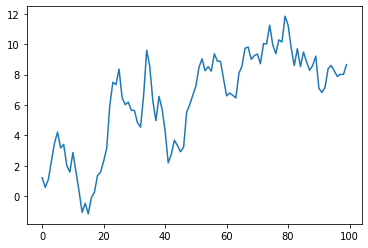

In [6]:
putativeDriver = np.cumsum(rand.normal(0,1,100))
figBeepBoop, axBeepBoop = plt.subplots(1)
axBeepBoop.plot(putativeDriver)
plt.show()

0.18657843900310203 0.10094332476119777


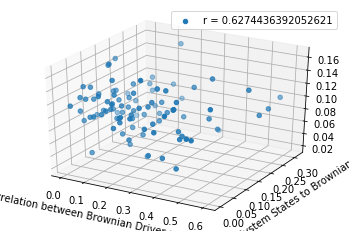

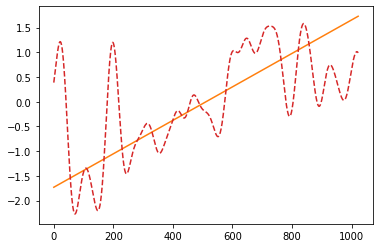

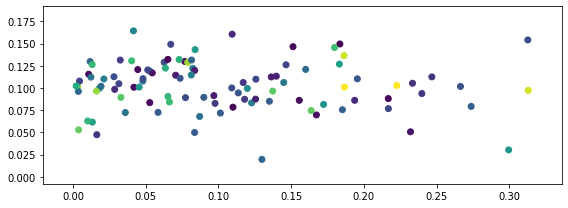

In [14]:
# choose best putative driver
bestPutativeDriverObjectivelyIndex = np.argsort(correlation)[-1]
bestPutativeDriverObjectively = putativeDrivers[bestPutativeDriverObjectivelyIndex,:]

print(CCMvalues[bestPutativeDriverObjectivelyIndex],CCMReverseValues[bestPutativeDriverObjectivelyIndex])

CCMReverseValuesStandardized = abs(standardize(CCMReverseValues))
sortedCCM = np.argsort(CCMvalues)
for i in range(sortedCCM.shape[0]):
    if CCMReverseValuesStandardized[sortedCCM[i]] < 1:
        bestPutativeDriverFromData = putativeDrivers[sortedCCM[i]]

# figBrown, axBrown = plt.subplots(2,figsize=(8,6))
figBrown1 = plt.figure()
figBrown2 = plt.figure()
axBrown1 = figBrown1.add_subplot(projection="3d")
axBrown2 = figBrown2.add_subplot()
figBrown3, axBrown3 = plt.subplots(1, figsize=(8,3))

axBrown3.scatter(CCMvalues,CCMReverseValues,c=abs(correlation))
# axBrown3[0].scatter(abs(correlation),CCMvalues)
# axBrown3[1].scatter(CCMvalues,CCMReverseValues,c=abs(correlation))
# axBrown3[2].scatter(CCMReverseValues,abs(correlation))

axBrown1.scatter(abs(correlation),CCMvalues,CCMReverseValues)
axBrown1.set_xlabel("Correlation between Brownian Driver and True Driver")
axBrown1.set_ylabel("CCM from System States to Brownian Driver")
axBrown1.legend(["r = {R}".format(R=np.dot(abs(correlation),CCMvalues)/(la.norm(abs(correlation))*la.norm(CCMvalues)))])

axBrown2.plot(standardize(gts),c="tab:orange")
# axBrown2.plot(standardize(bestPutativeDriverFromData),c="tab:blue")
axBrown2.plot(standardize(bestPutativeDriverObjectively),"--",c="tab:red")

plt.tight_layout()
plt.show()

In [ ]:
# GP of original data
print(Xemb.shape[0],Xemb.shape[0])
GPCovarianceMatrix = np.fromfunction(lambda i,j:tau*np.exp(-phi*la.norm(Xemb[i,:]-Xemb[j,:],axis=2)**2),(Xemb.shape[0],Xemb.shape[0]),dtype=int)
figGP, axGP = plt.subplots(1)

pltGPCov = axGP.imshow(GPCovarianceMatrix)
figGP.colorbar(pltGPCov)
plt.show()

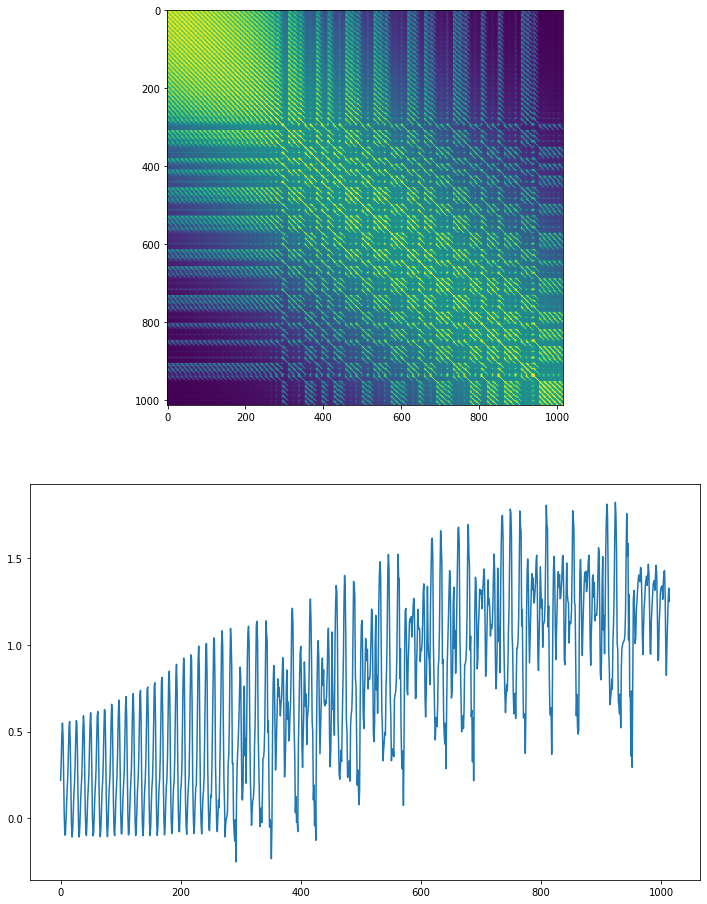

In [129]:
nDrivers = 1

# GPDriverCovarMatrix = np.maximum(GPCovarianceMatrix, putativeDriverCovarMatrix[:-embdim,:-embdim])
GPDriverCovarMatrix = GPCovarianceMatrix + putativeDriverCovarMatrix[:-embdim,:-embdim]
# print(GPDriverCovarMatrix)

figGPDriver, axGPDriver = plt.subplots(2,figsize=(12,16))

pltGPCovDriver = axGPDriver[0].imshow(GPDriverCovarMatrix)
figGP.colorbar(pltGPCovDriver)

for i in range(nDrivers):
    axGPDriver[1].plot(rand.multivariate_normal(np.zeros(GPDriverCovarMatrix.shape[0]),GPDriverCovarMatrix))

plt.show()